In [1]:
%%capture
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.databases
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.visualizations.git >/dev/null
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.EEG_Tensorflow_models@Marcos-L-patch-1
!pip install -U git+https://github.com/keisen/tf-keras-vis
!pip install -U keras==3.2.1
!pip install -U tensorflow
!pip install -U tf_keras
!pip install umap-learn
!pip install pyrcca

In [2]:
import pickle as pkl
import os
import time
from shutil import copy2
import json

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pandas import isna
import tensorflow as tf
#from google.colab import files
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedShuffleSplit
from rcca import CCA
from sklearn.manifold import TSNE
from sklearn.metrics import cohen_kappa_score, roc_auc_score, accuracy_score, \
                            f1_score, recall_score, precision_score
import tensorflow_probability as tfp
from scipy.signal import freqz, filtfilt, resample
from scipy.signal import butter as bw
from tf_keras_vis import layercam, scorecam, gradcam_plus_plus, gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore, InactiveScore
import umap

from gcpds.databases import GIGA_MI_ME
from gcpds.visualizations.topoplots import topoplot
from EEG_Tensorflow_models.Models import DeepConvNet, ShallowConvNet, EEGNet, TCNet_fusion

2024-10-22 13:36:52.881972: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-22 13:36:52.906092: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-22 13:36:52.913243: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Define variables, functions, and classes

## Variables

In [3]:
channels = ['Fp1','Fpz','Fp2',
            'AF7','AF3','AFz','AF4','AF8',
            'F7','F5','F3','F1','Fz','F2','F4','F6','F8',
            'FT7','FC5','FC3','FC1','FCz','FC2','FC4','FC6','FT8',
            'T7','C5','C3','C1','Cz','C2','C4','C6','T8',
            'TP7','CP5','CP3','CP1','CPz','CP2','CP4','CP6','TP8',
            'P9','P7','P5','P3','P1','Pz','P2','P4','P6','P8','P10',
            'PO7','PO3','POz','PO4','PO8',
            'O1','Oz','O2',
            'Iz']

areas = {
    'Frontal': ['Fpz', 'AFz', 'Fz', 'FCz'],
    'Frontal Right': ['Fp2','AF4','AF8','F2','F4','F6','F8',],
    'Central Right': ['FC2','FC4','FC6','FT8','C2','C4','C6','T8','CP2','CP4','CP6','TP8',],
    'Posterior Right': ['P2','P4','P6','P8','P10','PO4','PO8','O2',],
    #'Central': ['Cz'],
    'Posterior': ['CPz','Pz', 'Cz','POz','Oz','Iz',],
    'Posterior Left': ['P1','P3','P5','P7','P9','PO3','PO7','O1',],
    'Central Left': ['FC1','FC3','FC5','FT7','C1','C3','C5','T7','CP1','CP3','CP5','TP7',],
    'Frontal Left': ['Fp1','AF3','AF7','F1','F3','F5','F7',],
}

arcs = [
    #'hemispheres',
    'areas',
    'channels',
]

In [4]:
db = GIGA_MI_ME('/kaggle/input/giga-science-gcpds/GIGA_MI_ME')
load_args = dict(db = db,
                 eeg_ch_names = channels,
                 fs = db.metadata['sampling_rate'],
                 f_bank = np.asarray([[4., 40.]]),
                 vwt = np.asarray([[2.5, 5]]),
                 new_fs = 128.)

## Classes

### Mateo's Code

In [5]:
def butterworth_digital_filter(X, N, Wn, btype, fs, axis=-1, padtype=None, padlen=0, method='pad', irlen=None):
  """
  Apply digital butterworth filter
  INPUT
  ------
  1. X: (D array)
    array with signals.
  2. N: (int+)
    The order of the filter.
  3. Wn: (float+ or 1D array)
    The critical frequency or frequencies. For lowpass and highpass filters, Wn is a scalar; for bandpass and bandstop filters, Wn is a length-2 vector.
    For a Butterworth filter, this is the point at which the gain drops to 1/sqrt(2) that of the passband (the “-3 dB point”).
    If fs is not specified, Wn units are normalized from 0 to 1, where 1 is the Nyquist frequency (Wn is thus in half cycles / sample and defined as 2*critical frequencies / fs). If fs is specified, Wn is in the same units as fs.
  4. btype: (str) {‘lowpass’, ‘highpass’, ‘bandpass’, ‘bandstop’}
    The type of filter
  5. fs: (float+)
    The sampling frequency of the digital system.
  6. axis: (int), Default=1.
    The axis of x to which the filter is applied.
  7. padtype: (str) or None, {'odd', 'even', 'constant'}
    This determines the type of extension to use for the padded signal to which the filter is applied. If padtype is None, no padding is used. The default is ‘odd’.
  8. padlen: (int+) or None, Default=0
    The number of elements by which to extend x at both ends of axis before applying the filter. This value must be less than x.shape[axis] - 1. padlen=0 implies no padding.
  9. method: (str), {'pad', 'gust'}
    Determines the method for handling the edges of the signal, either “pad” or “gust”. When method is “pad”, the signal is padded; the type of padding is determined by padtype
    and padlen, and irlen is ignored. When method is “gust”, Gustafsson’s method is used, and padtype and padlen are ignored.
  10. irlen: (int) or None, Default=nONE
    When method is “gust”, irlen specifies the length of the impulse response of the filter. If irlen is None, no part of the impulse response is ignored.
    For a long signal, specifying irlen can significantly improve the performance of the filter.
  OUTPUT
  ------
  X_fil: (D array)
    array with filtered signals.
  """
  b, a = bw(N, Wn, btype, analog=False, output='ba', fs=fs)
  return filtfilt(b, a, X, axis=axis, padtype=padtype, padlen=padlen, method=method, irlen=irlen)

class TimeFrequencyRpr(BaseEstimator, TransformerMixin):
  """
  Time frequency representation of EEG signals.

  Parameters
  ----------
    1. sfreq:  (float) Sampling frequency in Hz.
    2. f_bank: (2D array) Filter banks Frequencies. Default=None
    3. vwt:    (2D array) Interest time windows. Default=None
  Methods
  -------
    1. fit(X, y=None)
    2. transform(X, y=None)
  """
  def __init__(self, sfreq, f_bank=None, vwt=None):
    self.sfreq = sfreq
    self.f_bank = f_bank
    self.vwt = vwt
# ------------------------------------------------------------------------------

  def _validation_param(self):
    """
    Validate Time-Frequency characterization parameters.
    INPUT
    -----
      1. self
    ------
      2. None
    """
    if self.sfreq <= 0:
      raise ValueError('Non negative sampling frequency is accepted')


    if self.f_bank is None:
      self.flag_f_bank = False
    elif self.f_bank.ndim != 2:
      raise ValueError('Band frequencies have to be a 2D array')
    else:
      self.flag_f_bank = True

    if self.vwt is None:
      self.flag_vwt = False
    elif self.vwt.ndim != 2:
      raise ValueError('Time windows have to be a 2D array')
    else:
      self.flag_vwt = True

# ------------------------------------------------------------------------------
  def _filter_bank(self, X):
    """
    Filter bank Characterization.
    INPUT
    -----
      1. X: (3D array) set of EEG signals, shape (trials, channels, time_samples)
    OUTPUT
    ------
      1. X_f: (4D array) set of filtered EEG signals, shape (trials, channels, time_samples, frequency_bands)
    """
    X_f = np.zeros((X.shape[0], X.shape[1], X.shape[2], self.f_bank.shape[0])) #epochs, Ch, Time, bands
    for f in np.arange(self.f_bank.shape[0]):
      X_f[:,:,:,f] = butterworth_digital_filter(X, N=5, Wn=self.f_bank[f], btype='bandpass', fs=self.sfreq)
    return X_f

# ------------------------------------------------------------------------------
  def _sliding_windows(self, X):
    """
    Sliding Windows Characterization.
    INPUT
    -----
      1. X: (3D array) set of EEG signals, shape (trials, channels, time_samples)
    OUTPUT
    ------
      1. X_w: (4D array) shape (trials, channels, window_time_samples, number_of_windows)
    """
    window_lenght = int(self.sfreq*self.vwt[0,1] - self.sfreq*self.vwt[0,0])
    X_w = np.zeros((X.shape[0], X.shape[1], window_lenght, self.vwt.shape[0]))
    for w in np.arange(self.vwt.shape[0]):
        X_w[:,:,:,w] = X[:,:,int(self.sfreq*self.vwt[w,0]):int(self.sfreq*self.vwt[w,1])]
    return X_w

# ------------------------------------------------------------------------------
  def fit(self, X, y=None):
    """
    fit.
    INPUT
    -----
      1. X: (3D array) set of EEG signals, shape (trials, channels, time_samples)
      2. y: (1D array) target labels. Default=None
    OUTPUT
    ------
      1. None
    """
    pass

# ------------------------------------------------------------------------------
  def transform(self, X, y=None):
    """
    Time frequency representation of EEG signals.
    INPUT
    -----
      1. X: (3D array) set of EEG signals, shape (trials, channels, times)
    OUTPUT
    ------
      1. X_wf: (5D array) Time-frequency representation of EEG signals, shape (trials, channels, window_time_samples, number_of_windows, frequency_bands)
    """
    self._validation_param()     #Validate sfreq, f_freq, vwt

    #Avoid edge effects of digital filter, 1st:fbk, 2th:vwt
    if self.flag_f_bank:
        X_f = self._filter_bank(X)
    else:
        X_f = X[:,:,:,np.newaxis]

    if self.flag_vwt:
      X_wf = []
      for f in range(X_f.shape[3]):
        X_wf.append(self._sliding_windows(X_f[:,:,:,f]))
      X_wf = np.stack(X_wf, axis=-1)
    else:
      X_wf = X_f[:,:,:,np.newaxis,:]

    return X_wf

def kappa(y_true, y_pred):
    return cohen_kappa_score(np.argmax(y_true, axis = 1), np.argmax(y_pred, axis = 1))

# def minmax_norm(x):
#     x = x - np.min(x)
#     x = x/np.max(x)
#     return x

### LayerCam

In [6]:
class RFFKernel(tf.keras.layers.Layer):
    def __init__(self, n_features=1, scale = None, **kwargs):
        super().__init__(**kwargs)
        self.n_features = n_features
        self.initializer = tf.keras.initializers.Constant(value=scale)

    def build(self, batch_input_shape):
        """
        """
        self.sigma = self.add_weight(name = 'sigma_scale',
                              shape = (),
                              initializer = self.initializer,
                              trainable = False)

        self.features = self.add_weight(
                        name="features",
                        shape=(batch_input_shape[2], self.n_features),
                        dtype=tf.float32,
                        initializer=tf.keras.initializers.RandomNormal(stddev=1.0),
                        trainable=True,)

        self.bias = self.add_weight(
                        name="bias",
                        shape=(self.n_features,),
                        dtype=tf.float32,
                        initializer=tf.keras.initializers.RandomUniform(minval=0.0, maxval=2 * np.pi),
                        trainable=True,)

        super().build(batch_input_shape)

    def call(self, X):
        X = tf.transpose(X, perm  = (0, 3, 1, 2)) #(N, F, C, T)
        X = X * self.sigma
        phi = tf.matmul(a = X, b = self.features)
        phi = tf.nn.bias_add(phi, self.bias)
        phi = tf.cos(phi)
        kernel = tf.matmul(phi, phi, transpose_b = True)
        norm_kernel = tf.linalg.diag_part(kernel, )
        norm_kernel = tf.expand_dims(norm_kernel,-1)
        norm_kernel = tf.matmul(norm_kernel, norm_kernel, transpose_b=True)
        norm_kernel = tf.math.sqrt(norm_kernel)
        kernel = tf.math.divide(kernel, norm_kernel)
        return kernel

class Triu(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.dims = batch_input_shape
        super().build(batch_input_shape)
    def call(self, X):
        dims = self.dims
        ones = tf.ones(dims[2:]) #(C, C)
        mask_a = tf.linalg.band_part(ones, 0, -1) #Upper triangular matrix of 0s and 1s (C, C)
        mask_b = tf.linalg.band_part(ones, 0, 0)  #Diagonal matrix of 0s and 1s (C, C)
        mask = tf.cast(mask_a - mask_b, dtype=tf.bool) #Make a bool mask (C, C)
        triu = tf.boolean_mask(X, mask, axis = 2) #(N, F, C*(C-1)/2)
        triu.set_shape((dims[0], dims[1], int(dims[2]*(dims[3]-1)/2)))
        return triu
    
class get_triu(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, batch_input_shape):
        super().build(batch_input_shape)

    def call(self, X): 
        N, F, C, C = X.shape
        ones = tf.ones_like(X[0,0,...]) #(C, C)
        mask_a = tf.linalg.band_part(ones, 0, -1) #Upper triangular matrix of 0s and 1s (C, C)
        mask_b = tf.linalg.band_part(ones, 0, 0)  #Diagonal matrix of 0s and 1s (C, C)
        mask = tf.cast(mask_a - mask_b, dtype=tf.bool) #Make a bool mask (C, C)
        triu = tf.expand_dims(tf.boolean_mask(X, mask, axis = 2), axis = -1) #(N, F, C*(C-1)/2, 1)

        triu.set_shape([N,F,int(C*(C-1)/2),1])
        return triu

    def compute_output_shape(self, batch_input_shape):
        N, F, C, C = list(batch_input_shape)
        return tf.TensorShape([N, F, int(C*(C-1)/2),1])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config}

## Functions

In [7]:
def centering(K):
    n = K.shape[0]
    unit = np.ones([n, n])
    I = np.eye(n)
    H = I - unit / n
    return np.dot(np.dot(H, K), H)  # HKH are the same with KH, KH is the first centering, H(KH) do the second time, results are the sme with one time centering

In [8]:
def load_GIGA(db,
              sbj,
              eeg_ch_names,
              fs,
              f_bank,
              vwt,
              new_fs,
              run=None):

    index_eeg_chs = db.format_channels_selectors(channels = eeg_ch_names) - 1

    tf_repr = TimeFrequencyRpr(sfreq = fs, f_bank = f_bank, vwt = vwt)

    db.load_subject(sbj)
    if run == None:
        X, y = db.get_data(classes = ['left hand mi', 'right hand mi']) #Load MI classes, all channels {EEG}, reject bad trials, uV
    else:
        X, y = db.get_run(run, classes = ['left hand mi', 'right hand mi']) #Load MI classes, all channels {EEG}, reject bad trials, uV
    X = X[:, index_eeg_chs, :] #spatial rearrangement
    X = np.squeeze(tf_repr.transform(X))
    #Resampling
    if new_fs == fs:
        pass#print('No resampling, since new sampling rate same.')
    else:
        print("Resampling from {:f} to {:f} Hz.".format(fs, new_fs))
        X = resample(X, int((X.shape[-1]/fs)*new_fs), axis = -1)

    return X, y

In [9]:
def get_tuned_model(nb_classes: int,
                    Chans: int,
                    Samples: int,
                    l1: int = 0,
                    l2: int = 0,
                    dropoutRate: float = 0.5,
                    filters: int = 1,
                    maxnorm: float = 2.0,
                    maxnorm_last_layer: float = 0.5,
                    kernel_time_1: int = 20,
                    n_features: int = 1024,
                    scale: float = 0.01,
                    strid_filter_time_1: int = 1,
                    bias_spatial: bool = False) -> tf.keras.Model:


    input_main   = tf.keras.layers.Input((Chans, Samples, 1),name='Input')

    block        = tf.keras.layers.Conv2D(filters,(1,kernel_time_1),strides=(1,strid_filter_time_1),
                            use_bias=bias_spatial,
                            kernel_constraint = tf.keras.constraints.max_norm(maxnorm, axis=(0,1,2))
                            )(input_main)

    block        = tf.keras.layers.BatchNormalization(epsilon=1e-05, momentum=0.1)(block)

    block        = tf.keras.layers.Activation('elu')(block)

    #*************************Kernel***********************************
    kernels      = RFFKernel(n_features = n_features, scale = scale)(block)

    block_triu   = Triu()(kernels)

    block        = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,-1))(block_triu)
    #*************************Kernel***********************************

    block        = tf.keras.layers.AveragePooling2D(pool_size=(kernels.shape[1],1),strides=(1,1))(block)

    block        = tf.keras.layers.BatchNormalization(epsilon=1e-05, momentum=0.1)(block)

    block        = tf.keras.layers.Activation('elu')(block)

    block        = tf.keras.layers.Flatten()(block)

    block        = tf.keras.layers.Dropout(dropoutRate)(block)

    block        = tf.keras.layers.Dense(nb_classes, kernel_regularizer=tf.keras.regularizers.L1L2(l1=l1,l2=l2),name='logits',
                              kernel_constraint = tf.keras.constraints.max_norm(maxnorm_last_layer)
                              )(block)

    softmax      = tf.keras.layers.Activation('softmax',name='output')(block)

    model = tf.keras.Model(inputs=input_main, outputs=[softmax, kernels, ])#block_w])

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3), loss=['categorical_crossentropy', None], loss_weights=[1.0, 0.0],)

    return model

In [10]:
class GFC(tf.keras.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, batch_input_shape):
        self.gammad = self.add_weight(name = 'gammad',
                                shape = (),
                                initializer = 'zeros',
                                trainable = True)
        super().build(batch_input_shape)

    def call(self, X): 
        X = tf.transpose(X, perm  = (0, 3, 1, 2)) #(N, F, C, T)
        R = tf.reduce_sum(tf.math.multiply(X, X), axis = -1, keepdims = True) #(N, F, C, 1)
        D  = R - 2*tf.matmul(X, X, transpose_b = (0, 1, 3, 2)) + tf.transpose(R, perm = (0, 1, 3, 2)) #(N, F, C, C)

        ones = tf.ones_like(D[0,0,...]) #(C, C)
        mask_a = tf.linalg.band_part(ones, 0, -1) #Upper triangular matrix of 0s and 1s (C, C)
        mask_b = tf.linalg.band_part(ones, 0, 0)  #Diagonal matrix of 0s and 1s (C, C)
        mask = tf.cast(mask_a - mask_b, dtype=tf.bool) #Make a bool mask (C, C)
        triu = tf.expand_dims(tf.boolean_mask(D, mask, axis = 2), axis = -1) #(N, F, C*(C-1)/2, 1)
        sigma = tfp.stats.percentile(tf.math.sqrt(triu), 50, axis = 2, keepdims = True) #(N, F, 1, 1)

        A = tf.math.exp(-1/(2*tf.pow(10., self.gammad)*tf.math.square(sigma))*D) #(N, F, C, C)
        A.set_shape(D.shape)
        return A

    def compute_output_shape(self, batch_input_shape):
        N, C, T, F = batch_input_shape#.as_list()
        return tf.TensorShape([N, F, C, C])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config}

def KREEGNet(number_of_classes: int,
          number_of_channels: int,
          number_of_time_samples: int, 
          dropout_rate: float,
          kernLength: int,
          F1: int, 
          D: int,
          F2: int,
          norm_rate: int,
          dropout_type: str):
    """ Keras Implementation of EEGNet
    http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta
    Note that this implements the newest version of EEGNet and NOT the earlier
    version (version v1 and v2 on arxiv). We strongly recommend using this
    architecture as it performs much better and has nicer properties than
    our earlier version. For example:
        
        1. Depthwise Convolutions to learn spatial filters within a 
        temporal convolution. The use of the depth_multiplier option maps 
        exactly to the number of spatial filters learned within a temporal
        filter. This matches the setup of algorithms like FBCSP which learn 
        spatial filters within each filter in a filter-bank. This also limits 
        the number of free parameters to fit when compared to a fully-connected
        convolution. 
        
        2. Separable Convolutions to learn how to optimally combine spatial
        filters across temporal bands. Separable Convolutions are Depthwise
        Convolutions followed by (1x1) Pointwise Convolutions. 
        
    
    While the original paper used Dropout, we found that SpatialDropout2D 
    sometimes produced slightly better results for classification of ERP 
    signals. However, SpatialDropout2D significantly reduced performance 
    on the Oscillatory dataset (SMR, BCI-IV Dataset 2A). We recommend using
    the default Dropout in most cases.
        
    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the 
    kernel lengths for double the sampling rate, etc). Note that we haven't 
    tested the model performance with this rule so this may not work well. 
    
    The model with default parameters gives the EEGNet-8,2 model as discussed
    in the paper. This model should do pretty well in general, although it is
	advised to do some model searching to get optimal performance on your
	particular dataset.
    We set F2 = F1 * D (number of input filters = number of output filters) for
    the SeparableConv2D layer. We haven't extensively tested other values of this
    parameter (say, F2 < F1 * D for compressed learning, and F2 > F1 * D for
    overcomplete). We believe the main parameters to focus on are F1 and D. 
    Inputs:
        
      nb_classes      : int, number of classes to classify
      number_of_channels, number_of_time_samples  : number of channels and time points in the EEG data
      dropout_rate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.     
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropout_type     : Either SpatialDropout2D or Dropout, passed as a string.
    """
    
    if dropout_type == 'SpatialDropout2D':
        dropout_type = tf.keras.layers.SpatialDropout2D
    elif dropout_type == 'Dropout':
        dropout_type = tf.keras.layers.Dropout
    else:
        raise ValueError('dropout_type must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input_   = tf.keras.layers.Input(shape = (number_of_channels, number_of_time_samples, 1))

    ##################################################################
    #Temporal Convolution
    block1       = tf.keras.layers.Conv2D(F1, (1, kernLength), padding = 'same',
                          name = 'Temporal_Conv2D',
                          use_bias = False)(input_)
    block1       = tf.keras.layers.BatchNormalization()(block1)
    adj_mat      = GFC(name = 'gfc')(block1)
    
    ##################################################################
    #Spatial Convolution
    block1       = tf.keras.layers.DepthwiseConv2D((number_of_channels, 1),
                                   name = 'Spatial_Depth_wise_Conv2D',
                                   depth_multiplier = D,
                                   use_bias = False, 
                                   depthwise_constraint = tf.keras.constraints.max_norm(1.))(block1)
    block1       = tf.keras.layers.BatchNormalization()(block1)
    block1       = tf.keras.layers.Activation('elu')(block1)
    block1       = tf.keras.layers.AveragePooling2D((1, 4))(block1)
    block1       = dropout_type(dropout_rate)(block1)
    
    ##################################################################
    #Separable Convolution
    block2       = tf.keras.layers.SeparableConv2D(F2, (1, 16), padding = 'same',
                                   name = 'Separable_Conv2D',
                                   use_bias = False)(block1)
    block2       = tf.keras.layers.BatchNormalization()(block2)
    block2       = tf.keras.layers.Activation('elu')(block2)
    block2       = tf.keras.layers.AveragePooling2D((1, 8))(block2)
    block2       = dropout_type(dropout_rate)(block2)
    
    ##################################################################
    # Classification block
    flatten      = tf.keras.layers.Flatten(name = 'flatten')(block2)
    dense        = tf.keras.layers.Dense(number_of_classes, name = 'output', 
                         kernel_constraint = tf.keras.constraints.max_norm(norm_rate))(flatten)
    softmax      = tf.keras.layers.Activation('softmax', name = 'out_activation')(dense)
    
    return tf.keras.Model(inputs=input_, outputs = [softmax, adj_mat])


def KCS_FCNet(nb_classes: int,
              Chans: int,
              Samples: int,
              l1: int = 0, 
              l2: int = 0, 
              dropoutRate: float = 0.5,
              filters: int = 1, 
              maxnorm: float = 2.0,
              maxnorm_last_layer: float = 0.5,
              kernel_time_1: int = 20,
              strid_filter_time_1: int = 1,
              bias_spatial: bool = False):


    input_main   = tf.keras.layers.Input((Chans, Samples, 1),name='Input')                    
    
    block        = tf.keras.layers.Conv2D(filters,(1,kernel_time_1),strides=(1,strid_filter_time_1),
                                            use_bias=bias_spatial,
                                            kernel_constraint = tf.keras.constraints.max_norm(maxnorm, axis=(0,1,2))
                                            )(input_main)
    
    block        = tf.keras.layers.BatchNormalization(epsilon=1e-05, momentum=0.1)(block)

    block        = tf.keras.layers.Activation('elu')(block)      
    
    block        = GFC()(block)

    block        = get_triu()(block)

    block        = tf.keras.layers.AveragePooling2D(pool_size=(block.shape[1],1),strides=(1,1))(block)
    
    block        = tf.keras.layers.BatchNormalization(epsilon=1e-05, momentum=0.1)(block)

    block        = tf.keras.layers.Activation('elu')(block) 
    
    block        = tf.keras.layers.Flatten()(block)    

    block        = tf.keras.layers.Dropout(dropoutRate)(block) 

    block        = tf.keras.layers.Dense(nb_classes, kernel_regularizer=tf.keras.regularizers.L1L2(l1=l1,l2=l2),name='logits',
                              kernel_constraint = tf.keras.constraints.max_norm(maxnorm_last_layer)
                              )(block)

    softmax      = tf.keras.layers.Activation('softmax',name='output')(block)
    
    return tf.keras.Model(inputs=input_main, outputs=softmax)

In [11]:
def load_model(path:str, model_args:dict) -> tf.keras.Model:
    if path.endswith('.keras'):
        os.system(f'unzip -o {path} -d ./tmp/')
        path = './tmp/model.weights.h5'
        with open('./tmp/config.json', 'rb') as f:
            config = json.load(f)
        model_args['n_features'] = config['config']['layers'][4]['config']['n_features']
        model_args['scale'] = config['config']['layers'][4]['config']['scale']

    model = get_tuned_model(**model_args)
    model.load_weights(path)
    return model

In [12]:
def get_model(model_name, nb_classes = 2, weights_path = None):
    if model_name == 'DeepConvNet':
        model_params = dict(nb_classes = nb_classes,
                          dropoutRate = 0.5, version='2018')
        model = DeepConvNet(**model_params, Chans = 64, Samples = 320)
        model.load_weights(weights_path)

    elif model_name == 'ShallowConvNet':
        model_params = dict(nb_classes = nb_classes,
                          dropoutRate = 0.5,
                          version = '2018')
        model = ShallowConvNet(**model_params, Chans = 64, Samples = 320)
        model.load_weights(weights_path)

    elif model_name == 'EEGNet':
        model_params = dict(nb_classes = nb_classes,
                          dropoutRate = 0.5,
                          kernLength = 32,
                          F1 = 8,
                          D = 2,
                          F2 = 16,
                          norm_rate = 0.25,
                          dropoutType = 'Dropout')
        model = EEGNet(**model_params, Chans = 64, Samples = 320)
        model.load_weights(weights_path)

    elif model_name == 'TCNet_fusion':
        model_params = dict(nb_classes = nb_classes,
                          layers = 2,
                          kernel_s = 4,
                          filt = 12,
                          dropout = 0.3,
                          activation = 'relu',
                          F1 = 24,
                          D = 2,
                          kernLength = 32,
                          N_residuals = 2)
        model = TCNet_fusion(**model_params, Chans = 64, Samples = 320)
        model.load_weights(weights_path)
    elif model_name == 'KREEGNet':
        model_params = dict(number_of_classes = 2,
                          dropout_rate = 0.5,
                          kernLength = int(load_args['new_fs']/4),
                          F1 = 8,
                          D = 2,
                          F2 = 16,
                          norm_rate = 0.25,
                          dropout_type = 'Dropout')
        model = KREEGNet(**model_params, number_of_channels = 64, number_of_time_samples = 320)
        model.load_weights(weights_path)
    elif model_name == 'KCS-FCNet':
        try:
            model_params = dict(nb_classes = 2,
                              dropoutRate = 0.5,
                              kernel_time_1 = 50,
                              strid_filter_time_1 = 1,
                              filters = 4,
                              maxnorm = 2.0,
                              maxnorm_last_layer = 0.5,)
            model = KCS_FCNet(**model_params, Chans = 64, Samples = 320)
            model.load_weights(weights_path)
        except Exception as e:
            error = str(e)
            filters = error.index('Received: value.shape=(')+33
            kernel_time = error.index('Received: value.shape=(')+26
            model_params = dict(nb_classes = 2,
                              dropoutRate = 0.5,
                              kernel_time_1 = int(error[kernel_time:kernel_time + 2]),
                              strid_filter_time_1 = 1,
                              filters = int(error[filters:filters+1]),
                              maxnorm = 2.0,
                              maxnorm_last_layer = 0.5,)
            model = KCS_FCNet(**model_params, Chans = 64, Samples = 320)
            model.load_weights(weights_path)
    else:
        model_args = dict(nb_classes = 2,
                          Chans = 64,
                          Samples = int(2.5*128),
                          dropoutRate = 0.25,
                          kernel_time_1 = int(128/4),
                          filters = 3,)
        model = load_model(weights_path, model_args)

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3))
    return model

In [13]:
def to_categorical(y_pred):
    y_pred_categorical = []
    for i in y_pred:
        if i[0] >0.5:
            y_pred_categorical += [0]
        else:
            y_pred_categorical += [1]
    return np.array(y_pred_categorical)

In [14]:
def fcam(xtrial_ ,cam_true, cam_false=None, fs=128, fc1=4,fc2=40):
    vfreq = np.fft.rfftfreq(xtrial_.shape[2], 1/fs)
    f_ = (vfreq >=fc1) & (vfreq<=fc2) #frequency band
    
    xtrial_f = np.fft.rfft(xtrial_, axis=2) #Fourier of EEG  
    cam_f = np.fft.rfft(cam_true, axis=2) # Fourier of CAM
    cam_f_ = abs(cam_f) #Find magnitudes
    cam_f_[:,:,~f_] = 0 # Filter CAM spectrum
    cam_f_ /= np.max(cam_f_) # Normalize Spectrum
    cam_f_ = cam_f_*2 + 1
    xtrial_f_ = xtrial_f * cam_f_ # Filter EEG using CAM
    xtrial_n = np.fft.irfft(xtrial_f_,axis=2) #Return EEG to time representation
    if np.all(cam_false != None):
        cam_f_neg = np.fft.rfft(cam_false, axis=2) # Fourier of CAM of neg class
        cam_f_neg = abs(cam_f_neg) #Find magnitudes
        cam_f_neg[:,:,~f_] = 0 # Filter CAM spectrum
        cam_f_neg /= np.max(cam_f_neg) # Normalize Spectrum
        cam_f_neg = cam_f_neg*2 + 1
        xtrial_f_neg = xtrial_f * cam_f_neg # Filter EEG using CAM
        xtrial_n_neg = np.fft.irfft(xtrial_f_neg,axis=2) #Return EEG to time representation
        return xtrial_n, xtrial_n_neg
    return xtrial_n

# Cams

In [15]:
n_sbj = 50
subjects = np.arange(52)+1
subjects = np.delete(subjects,[28,33]) # delete 29 and 34

i = 4

model_ = ['KCS-FCNet_RFF', 'TCNet_fusion', 'DeepConvNet', 'EEGNet', 'ShallowConvNet', 'KCS-FCNet', 'KREEGNet'][i]
models = ['/kaggle/input/rff-models/KCS-FCNet_RFF','/kaggle/input/rff-models/TCFusionNet',
         '/kaggle/input/rff-models/DeepConvNet','/kaggle/input/rff-models/EEGNet',
         '/kaggle/input/rff-models/ShallowConvNet', '/kaggle/input/rff-models/KCS-FCNet',
         '/kaggle/input/rff-models/KREEGNet']
models_root = models[i]

cam_to_use = [layercam.Layercam, gradcam.Gradcam, gradcam_plus_plus.GradcamPlusPlus, scorecam.Scorecam][0]

results = {}
for file_ in os.listdir(f'{models_root}/'):
    if file_.endswith('.pkl'):
        with open(f'{models_root}/{file_}', 'rb') as f:
            dic = pkl.load(f)
            results.update(dic)
results[14].keys()

dict_keys(['params', 'mean_acc', 'mean_kappa', 'mean_auc', 'mean_f1_left', 'mean_f1_right', 'mean_recall_left', 'mean_recall_right', 'mean_precision_left', 'mean_precision_right', 'std_acc', 'std_kappa', 'std_auc', 'std_f1_left', 'std_f1_right', 'std_recall_left', 'std_recall_right', 'std_precision_left', 'std_precision_right'])

In [16]:
Penultimate_layer = 1 + (model_ == 'TCNet_fusion')

In [17]:
model_

'ShallowConvNet'

In [18]:
f1_scores_left = []
recall_scores_left = []
precision_scores_left = []

f1_scores_right = []
recall_scores_right = []
precision_scores_right = []

accuracies = []
kappas = []
aucs = []
try:
    for sbj in subjects:
        f1_left = []
        recall_left = []
        precision_left = []

        f1_right = []
        recall_right = []
        precision_right = []

        acc = []
        kap = []
        auc = []

        if 'RFF' in model_:
            for fold in range(1,6):
                f1_left += [results[sbj][0][fold]['f1_left']]
                recall_left += [results[sbj][0][fold]['recall_left']]
                precision_left += [results[sbj][0][fold]['precision_left']]

                f1_right += [results[sbj][0][fold]['f1_right']]
                recall_right += [results[sbj][0][fold]['recall_right']]
                precision_right += [results[sbj][0][fold]['precision_right']]

                acc += [results[sbj][0][fold]['Accuracy']]
                kap += [results[sbj][0][fold]['kappa']]
                auc += [results[sbj][0][fold]['auc']]
        else:
            f1_left += [results[sbj]['mean_f1_left']]
            recall_left += [results[sbj]['mean_recall_left']]
            precision_left += [results[sbj]['mean_precision_left']]

            f1_right += [results[sbj]['mean_f1_right']]
            recall_right += [results[sbj]['mean_recall_right']]
            precision_right += [results[sbj]['mean_precision_right']]

            acc += [results[sbj]['mean_acc']]
            kap += [results[sbj]['mean_kappa']]
            auc += [results[sbj]['mean_auc']]

        f1_scores_left += [f1_left]
        recall_scores_left += [recall_left]
        precision_scores_left += [precision_left]

        f1_scores_right += [f1_right]
        recall_scores_right += [recall_right]
        precision_scores_right += [precision_right]

        accuracies += [acc]
        kappas += [kap]
        aucs += [auc]
except:
    pass

In [31]:
# Now we want to know which hyper parameter produced the best model
# Once we know this we can load that model from the models folder
C = len(channels)

true_cams = np.zeros((50,240,64,320))
false_cams = np.zeros((50,240,64,320))

accuracy_fold = np.zeros((50, 5))
kappas_fold = np.zeros((50, 5))
aucs_fold = np.zeros((50, 5))

accuracy_after = np.zeros((50, 5))
kappas_after = np.zeros((50, 5))
aucs_after = np.zeros((50, 5))

if model_ == 'KCS-FCNet':
    f1_scores_left = np.ones((50, 1))
    recall_scores_left = np.ones((50, 1))
    precision_scores_left = np.ones((50, 1))

    f1_scores_right = np.ones((50, 1))
    recall_scores_right = np.ones((50, 1))
    precision_scores_right = np.ones((50, 1))

    accuracies = np.ones((50, 1))
    kappas = np.ones((50, 1))
    aucs = np.ones((50, 1))

#pvalues_array = np.zeros((n_sbj, int(C*(C-1)/2), 8))
cam = {}
#metri = np.ones((n_sbj, 6))
n_sbj = 0
if 'RFF' in models_root:
    accuracy_fold = np.zeros((50, 5))
    kappas_fold = np.zeros((50, 5))
    aucs_fold = np.zeros((50, 5))

    accuracy_after = np.zeros((50, 5))
    kappas_after = np.zeros((50, 5))
    aucs_after = np.zeros((50, 5))
    start_time = time.time()
    for sbj in subjects:
        lam = 0.0
        r = []
        kap = []
        auc = []
        X_train, y_train = load_GIGA(sbj=sbj, **load_args)
        X_train = np.expand_dims(X_train, -1)

        SSS = StratifiedShuffleSplit(n_splits = 6, train_size=0.8, test_size=0.2, random_state = 23)
        partitions = list(SSS.split(X_train, tf.keras.utils.to_categorical(y_train,2)))

        for fold in range(1,6):
            x = X_train[partitions[fold][0]]
            y = y_train[partitions[fold][0]]
            x_val = X_train[partitions[fold][1]]
            y_val = y_train[partitions[fold][1]]

            #model = load_model(, model_args)
            model = get_model('Daniel', weights_path = f'{models_root}/Models/Sbj{sbj}_fold{fold}.keras')
            acc = results[sbj][0.0][fold]['Accuracy']
            kappa_ = results[sbj][0.0][fold]['kappa']
            auc = results[sbj][0.0][fold]['auc']
            if fold == 1:
                no_softmax_model = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)
                activation = no_softmax_model.predict(X_train, verbose = 0)
                y_pred = model.predict(X_train, verbose = 0)[0]
                n_trials = X_train.shape[0]
                cam_n_features = X_train.shape[1]*X_train.shape[2]

                lc = cam_to_use(model, model_modifier=ReplaceToLinear(), clone=False)
                ind_cam = lc(score = [CategoricalScore(list(y_train)),  # For 1st model output
                                                    InactiveScore(),            # For 2nd model output
                                            ],
                                        seed_input = X_train,
                                        penultimate_layer = 1,
                                        seek_penultimate_conv_layer = True,
                                        normalize_cam = False,
                                        expand_cam = True
                                        )
                norm_cam = lc(score = [CategoricalScore(list(abs(y_train-1))),  # For 1st model output
                                                    InactiveScore(),            # For 2nd model output
                                            ],
                                        seed_input = X_train,
                                        penultimate_layer = 1,
                                        seek_penultimate_conv_layer = True,
                                        normalize_cam = True,
                                        expand_cam = True
                                        )
                coherency = 0
                activation_cam = no_softmax_model.predict(X_train*(norm_cam[...,np.newaxis]*2+1), verbose = 0)
                cam[sbj] = ind_cam, y_train, y_pred, X_train, activation, activation_cam, tf.norm(ind_cam, axis = (1, 2)), tf.linalg.diag_part(coherency).numpy(), np.mean(acc), 
            tf.keras.backend.clear_session()
            
            y_pred_before = model.predict(x_val)[0]
            acc_before = tf.keras.metrics.CategoricalAccuracy()
            acc_before.update_state(tf.keras.utils.to_categorical(y_val, 2), y_pred_before)

            accuracy_fold[n_sbj, fold-1] = acc_before.result()
            kappas_fold[n_sbj, fold-1] = kappa_
            aucs_fold[n_sbj, fold-1] = auc
            
            y_pred_after = model.predict(x_val*(norm_cam[partitions[fold][1],...,np.newaxis]*2+1))[0]
            acc_after = tf.keras.metrics.CategoricalAccuracy()
            acc_after.update_state(tf.keras.utils.to_categorical(y_val, 2), y_pred_after)
            
            accuracy_after[n_sbj, fold-1] = acc_after.result()
        n_sbj += 1
else:
    accuracy_fold = np.ones((50, 1))
    kappas_fold = np.ones((50, 1))
    aucs_fold = np.ones((50, 1))

    accuracy_after = np.ones((50, 1))
    kappas_after = np.ones((50, 1))
    aucs_after = np.ones((50, 1))
    start_time = time.time()
    for sbj in subjects:
        acc = []
        kap = []
        auc = []
        
        X_train, y_train = load_GIGA(sbj=sbj, **load_args)
        X_train = np.expand_dims(X_train, -1)

        SSS = StratifiedShuffleSplit(n_splits = 5, test_size=0.2, random_state = 23)
        partitions = list(SSS.split(X_train, y_train))

        for fold in [4]:#range(5):
            x = X_train[partitions[fold][0]]
            y = y_train[partitions[fold][0]]
            x_val = X_train[partitions[fold][1]]
            y_val = y_train[partitions[fold][1]]

            model = get_model(model_, weights_path = f'{models_root}/Models/sbj{sbj}.h5')
            if model_ == 'KREEGNet':
                true_scores = [CategoricalScore(list(abs(y_train))),  # For 1st model output
                          InactiveScore()]
                false_scores = [CategoricalScore(list(abs(y_train-1))),  # For 1st model output
                          InactiveScore()]
                acc = results[sbj]['mean_acc']
                kappa_ = results[sbj]['mean_kappa']
                auc = results[sbj]['mean_auc']
                accuracies += [acc]
                kappas += [kappa_]
                aucs += [auc]

                y_pred = model.predict(X_train, verbose = 0)[0]
            elif model_ == 'KCS-FCNet':
                true_scores = [CategoricalScore(list(abs(y_train)))]
                false_scores = [CategoricalScore(list(abs(y_train-1)))]
                acc = np.mean(results[sbj]['mean_test_Accuracy'])
                kappa_ = np.mean(results[sbj]['mean_test_Kappa'])
                auc = np.mean(results[sbj]['mean_test_AUC'])
                accuracies[n_sbj, 0] = acc
                kappas[n_sbj, 0] = kappa_
                aucs[n_sbj, 0] = auc
                y_pred = model.predict(X_train, verbose = 0)
            else:
                true_scores = [CategoricalScore(list(abs(y_train)))]
                false_scores = [CategoricalScore(list(abs(y_train-1)))]
                acc = results[sbj]['mean_acc']
                kappa_ = results[sbj]['mean_kappa']
                auc = results[sbj]['mean_auc']
                y_pred = model.predict(X_train, verbose = 0)
            if fold == 4:
                no_softmax_model = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)
                activation = no_softmax_model.predict(X_train, verbose = 0)

                n_trials = X_train.shape[0]
                cam_n_features = X_train.shape[1]*X_train.shape[2]

                lc = cam_to_use(model, model_modifier=ReplaceToLinear(), clone=False)
                ind_cam = lc(score = true_scores,
                            seed_input = X_train,
                            penultimate_layer = Penultimate_layer,
                            seek_penultimate_conv_layer = True,
                            normalize_cam = False,
                            expand_cam = True
                            )
                false_cam = lc(score = false_scores,
                            seed_input = X_train,
                            penultimate_layer = Penultimate_layer,
                            seek_penultimate_conv_layer = True,
                            normalize_cam = False,
                            expand_cam = True
                            )
                
                #diff_cam = np.abs(ind_cam - false_cam)
                
                max_val_cams = np.max(np.concatenate((ind_cam[...,np.newaxis],
                                                      false_cam[...,np.newaxis]), axis=-1), axis=(1,2,3))[:,np.newaxis,np.newaxis]
                norm_cam_pos = ind_cam / max_val_cams
                norm_cam_neg = false_cam / max_val_cams
                
                eeg_filtered_pos = X_train*(norm_cam_pos[...,np.newaxis]*2+1)
                eeg_filtered_neg = X_train*(norm_cam_neg[...,np.newaxis]*2+1)
                
                for i in range(ind_cam.shape[0]):
                    true_cams[n_sbj,i] = ind_cam[i]
                    false_cams[n_sbj,i] = false_cam[i]
                
                score_cam_pos = no_softmax_model.predict(eeg_filtered_pos, verbose = 0) # Trials x Clases
                score_cam_neg = no_softmax_model.predict(eeg_filtered_neg, verbose = 0) # Trials x Clases
                
                joint_cams = np.append(score_cam_pos[...,np.newaxis], score_cam_neg[...,np.newaxis], axis=-1)
                activation_cam = np.zeros(score_cam_pos.shape)
                for i in range(activation_cam.shape[0]):
                    max_output = int(np.argmax(joint_cams[1])/2)
                    activation_cam[i] = joint_cams[i,:,max_output]
                
                cam[sbj] = ind_cam, y_train, y_pred, X_train, activation, activation_cam, tf.norm(ind_cam, axis = (1, 2)), partitions[fold][1], np.mean(acc), 
            tf.keras.backend.clear_session()
            
            y_pred_before = model.predict(x_val, verbose=0)
            acc_before = tf.keras.metrics.SparseCategoricalAccuracy()
            acc_before.update_state(y_val, y_pred_before)
            
            kappas_fold[n_sbj, 0] = np.mean(kappa_)
            aucs_fold[n_sbj, 0] = np.mean(auc)
            
            y_pred_after = tf.nn.softmax(activation_cam[partitions[fold][1]])
            acc_after = tf.keras.metrics.SparseCategoricalAccuracy()
            acc_after.update_state(y_val, y_pred_after)
            
            aucs_after[n_sbj, 0] = roc_auc_score(y_val, np.argmax(y_pred_after, axis=1))
            kappas_after[n_sbj, 0] = kappa(tf.keras.utils.to_categorical(y_val), y_pred_after)
            
            print(f'Sbj {sbj}: {acc_after.result() - acc_before.result()}; Is equal to PosCam?: {np.all(activation_cam == score_cam_pos)}')
            
            accuracy_fold[n_sbj, 0] = acc_before.result()
            accuracy_after[n_sbj, 0] = acc_after.result()
            if model_ == 'KCS-FCNet':
                f1_scores_left[n_sbj, 0] = f1_score(y_val, np.argmax(y_pred_before, axis=1), pos_label = 0, average = 'binary')
                f1_scores_right[n_sbj, 0] = f1_score(y_val, np.argmax(y_pred_before, axis=1), pos_label = 1, average = 'binary')
                recall_scores_left[n_sbj, 0] = recall_score(y_val, np.argmax(y_pred_before, axis=1), pos_label = 0, average = 'binary')
                recall_scores_right[n_sbj, 0] = recall_score(y_val, np.argmax(y_pred_before, axis=1), pos_label = 1, average = 'binary')
                precision_scores_left[n_sbj, 0] = precision_score(y_val, np.argmax(y_pred_before, axis=1), pos_label = 0, average = 'binary')
                precision_scores_right[n_sbj, 0] = precision_score(y_val, np.argmax(y_pred_before, axis=1), pos_label = 1, average = 'binary')
        n_sbj += 1
print(f'Final time: {time.time()-start_time}')

Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 1: 0.02499997615814209; Is equal to PosCam?: True
Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 2: 0.02499997615814209; Is equal to PosCam?: True
Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 3: 0.0; Is equal to PosCam?: True
Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 4: 0.0; Is equal to PosCam?: True
Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 5: 0.050000011920928955; Is equal to PosCam?: True
Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 6: 0.0; Is equal to PosCam?: True
Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 7: 0.1875; Is equal to PosCam?: True
Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 8: 0.07499998807907104; Is equal to PosCam?: True
Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 9: 0.0; Is equal to PosCam?: True
Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 10: 0.0; Is equal to PosCam?: True
Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 11: 0.10000002384185791; Is equal to PosCam?: True
Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 12: 0.05714285373687744; Is equal to PosCam?: True
Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 13: 0.0; Is equal to PosCam?: True
Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 14: 0.0; Is equal to PosCam?: True
Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 15: 0.025641024112701416; Is equal to PosCam?: True
Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 16: 0.07499998807907104; Is equal to PosCam?: True
Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 17: 0.050000011920928955; Is equal to PosCam?: True
Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 18: 0.0; Is equal to PosCam?: True
Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 19: 0.10344827175140381; Is equal to PosCam?: True
Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 20: 0.11764705181121826; Is equal to PosCam?: True
Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 21: 0.125; Is equal to PosCam?: True
Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 22: 0.02499997615814209; Is equal to PosCam?: True
Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 23: 0.07500004768371582; Is equal to PosCam?: True
Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 24: 0.0; Is equal to PosCam?: True
Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 25: 0.125; Is equal to PosCam?: True
Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 26: 0.0; Is equal to PosCam?: True
Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 27: 0.13513511419296265; Is equal to PosCam?: True
Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 28: 0.0; Is equal to PosCam?: True
Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 30: 0.039999961853027344; Is equal to PosCam?: True
Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 31: 0.02499997615814209; Is equal to PosCam?: True
Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 32: 0.050000011920928955; Is equal to PosCam?: True
Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 33: 0.025000035762786865; Is equal to PosCam?: True
Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 35: 0.0; Is equal to PosCam?: True
Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 36: 0.07692307233810425; Is equal to PosCam?: True
Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 37: 0.0; Is equal to PosCam?: True
Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 38: 0.10256409645080566; Is equal to PosCam?: True
Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 39: 0.0; Is equal to PosCam?: True
Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 40: 0.050000011920928955; Is equal to PosCam?: True
Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 41: 0.02499997615814209; Is equal to PosCam?: True
Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 42: 0.07499998807907104; Is equal to PosCam?: True
Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 43: 0.0; Is equal to PosCam?: True
Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 44: 0.0; Is equal to PosCam?: True
Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 45: 0.02499997615814209; Is equal to PosCam?: True
Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 46: 0.020833313465118408; Is equal to PosCam?: True
Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 47: 0.025641024112701416; Is equal to PosCam?: True
Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 48: 0.0; Is equal to PosCam?: True
Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 49: 0.025641024112701416; Is equal to PosCam?: True
Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 50: 0.0; Is equal to PosCam?: True
Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 51: 0.05128204822540283; Is equal to PosCam?: True
Resampling from 512.000000 to 128.000000 Hz.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sbj 52: 0.2749999761581421; Is equal to PosCam?: True
Final time: 920.1592841148376


In [21]:
np.save('True_Cams.npy',true_cams)
np.save('False_Cams.npy', false_cams)

In [22]:
print(f'{np.mean(f1_scores_left)};{np.std(f1_scores_left)}')
print(f'{np.mean(f1_scores_right)};{np.std(f1_scores_right)}')

0.7177199999999999;0.14659768620275013
0.7238600000000001;0.14415283694745656


In [23]:
print(f'{np.mean(recall_scores_left)};{np.std(recall_scores_left)}')
print(f'{np.mean(recall_scores_right)};{np.std(recall_scores_right)}')

0.7186800000000001;0.16038022820784364
0.7269599999999999;0.14390802062428626


In [24]:
print(f'{np.mean(precision_scores_left)};{np.std(precision_scores_left)}')
print(f'{np.mean(precision_scores_right)};{np.std(precision_scores_right)}')

0.7267;0.1349204580484368
0.7295800000000001;0.14878025272192544


In [25]:
print(f'Before \t After\t Increase')
i = 0
for before, after in zip(accuracy_fold, accuracy_after):
    print(f'Sbj {subjects[i]}: {np.mean(before):0.3f}\t {np.mean(after):0.3f}\t {np.mean(after)-np.mean(before):0.3f}')
    i += 1

Before 	 After	 Increase
Sbj 1: 0.975	 0.975	 0.000
Sbj 2: 0.975	 0.950	 -0.025
Sbj 3: 1.000	 1.000	 0.000
Sbj 4: 1.000	 0.975	 -0.025
Sbj 5: 0.950	 0.975	 0.025
Sbj 6: 1.000	 1.000	 0.000
Sbj 7: 0.792	 0.604	 -0.188
Sbj 8: 0.925	 0.925	 0.000
Sbj 9: 1.000	 1.000	 0.000
Sbj 10: 1.000	 0.975	 -0.025
Sbj 11: 0.900	 0.875	 -0.025
Sbj 12: 0.914	 0.914	 0.000
Sbj 13: 1.000	 1.000	 0.000
Sbj 14: 1.000	 0.975	 -0.025
Sbj 15: 0.974	 0.974	 0.000
Sbj 16: 0.925	 0.925	 0.000
Sbj 17: 0.950	 0.975	 0.025
Sbj 18: 1.000	 0.950	 -0.050
Sbj 19: 0.897	 0.759	 -0.138
Sbj 20: 0.882	 0.882	 0.000
Sbj 21: 0.875	 0.875	 0.000
Sbj 22: 0.975	 1.000	 0.025
Sbj 23: 0.900	 0.675	 -0.225
Sbj 24: 0.975	 0.975	 0.000
Sbj 25: 0.875	 0.900	 0.025
Sbj 26: 1.000	 1.000	 0.000
Sbj 27: 0.865	 0.811	 -0.054
Sbj 28: 1.000	 0.975	 -0.025
Sbj 30: 0.920	 0.920	 0.000
Sbj 31: 0.975	 0.900	 -0.075
Sbj 32: 0.950	 0.950	 0.000
Sbj 33: 0.950	 0.950	 0.000
Sbj 35: 1.000	 1.000	 0.000
Sbj 36: 0.923	 0.923	 0.000
Sbj 37: 1.000	 1.000

In [26]:
g1 = [0, 2, 3, 4, 5, 9, 12, 13, 22, 25, 27, 32, 34, 38, 40, 41, 43, 44, 45, 46, 47]
g2 = [7, 8, 11, 14, 17, 19, 20, 21, 23, 24, 29, 33, 36, 39, 42, 48, 49]
g3 = [1, 6, 10, 15, 16, 18, 26, 28, 30, 31, 35, 37]

try:
    os.mkdir('./gains')
except:
    pass

In [27]:
np.median(accuracy_after- accuracy_fold), np.std(accuracy_after- accuracy_fold)

(0.0, 0.04875647959162699)

In [28]:
print('Avg increase ACC')
for index, group_name in zip([g1,g2,g3], ['g1','g2','g3']):
    print(f'{group_name}: {np.mean(accuracy_after[index]- accuracy_fold[index]):0.3f} +/- {np.std(accuracy_after[index]- accuracy_fold[index]):0.3f}')

Avg increase ACC
g1: -0.016 +/- 0.048
g2: -0.006 +/- 0.030
g3: -0.042 +/- 0.061


In [29]:
print('Median increase ACC')
for index, group_name in zip([g1,g2,g3], ['g1','g2','g3']):
    print(f'{group_name}: {np.median(accuracy_after[index]- accuracy_fold[index]):0.3f} +/- {np.std(accuracy_after[index]- accuracy_fold[index]):0.3f}')

Median increase ACC
g1: 0.000 +/- 0.048
g2: 0.000 +/- 0.030
g3: -0.025 +/- 0.061


Sbj: 1


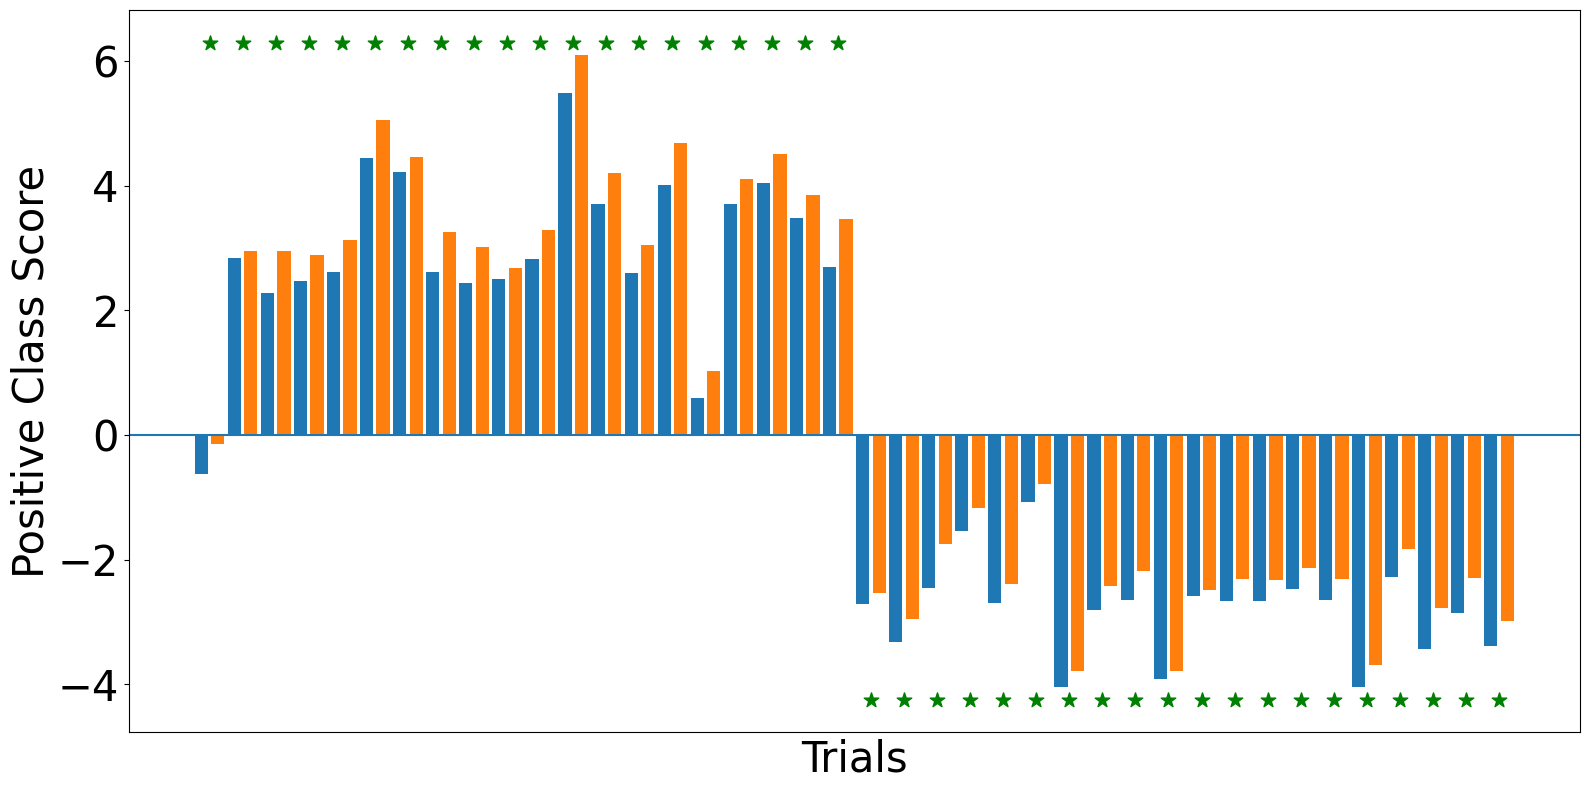

Sbj: 2


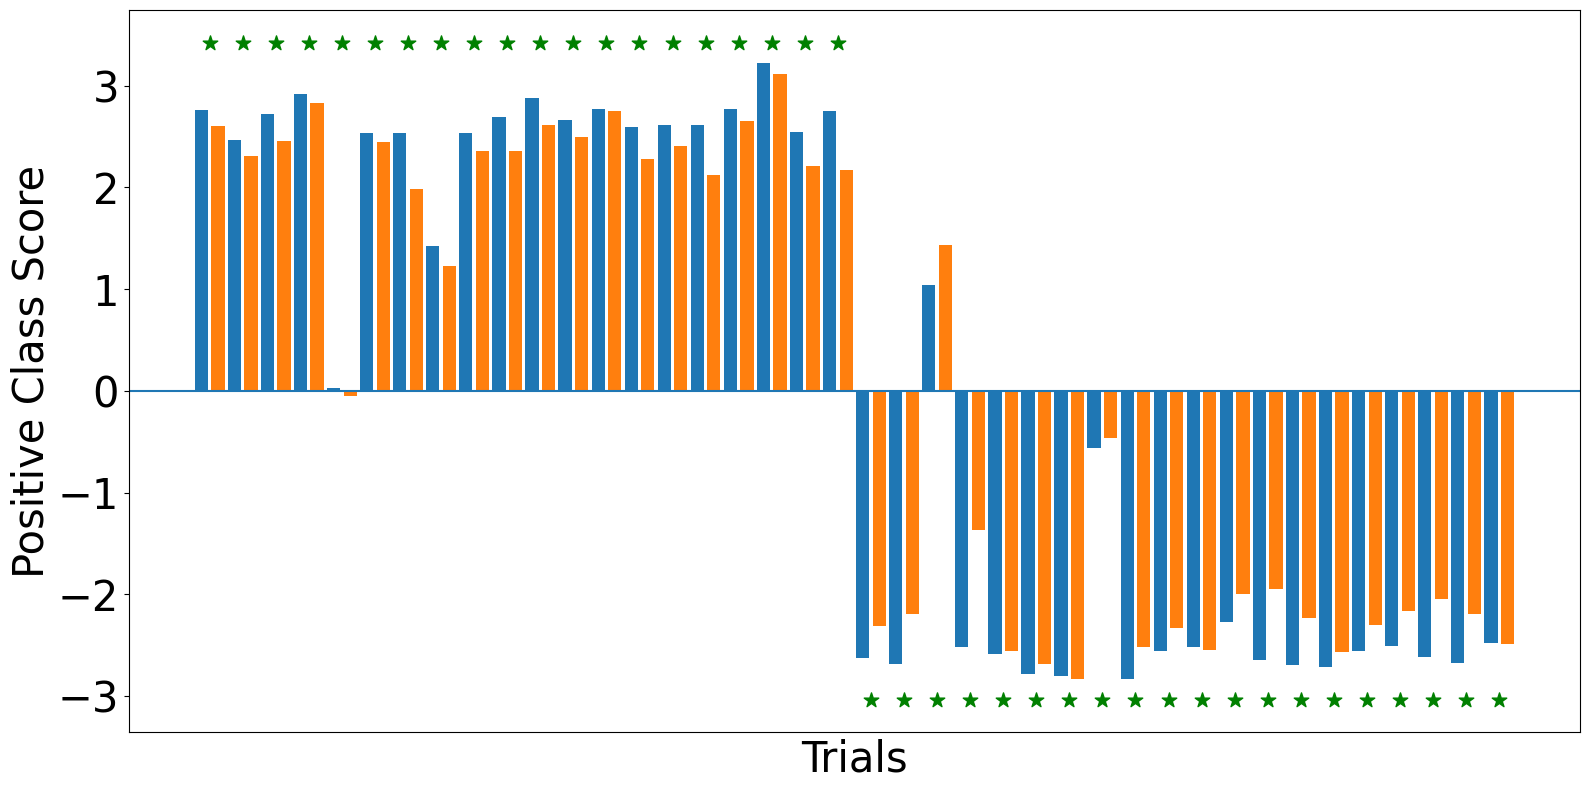

Sbj: 3


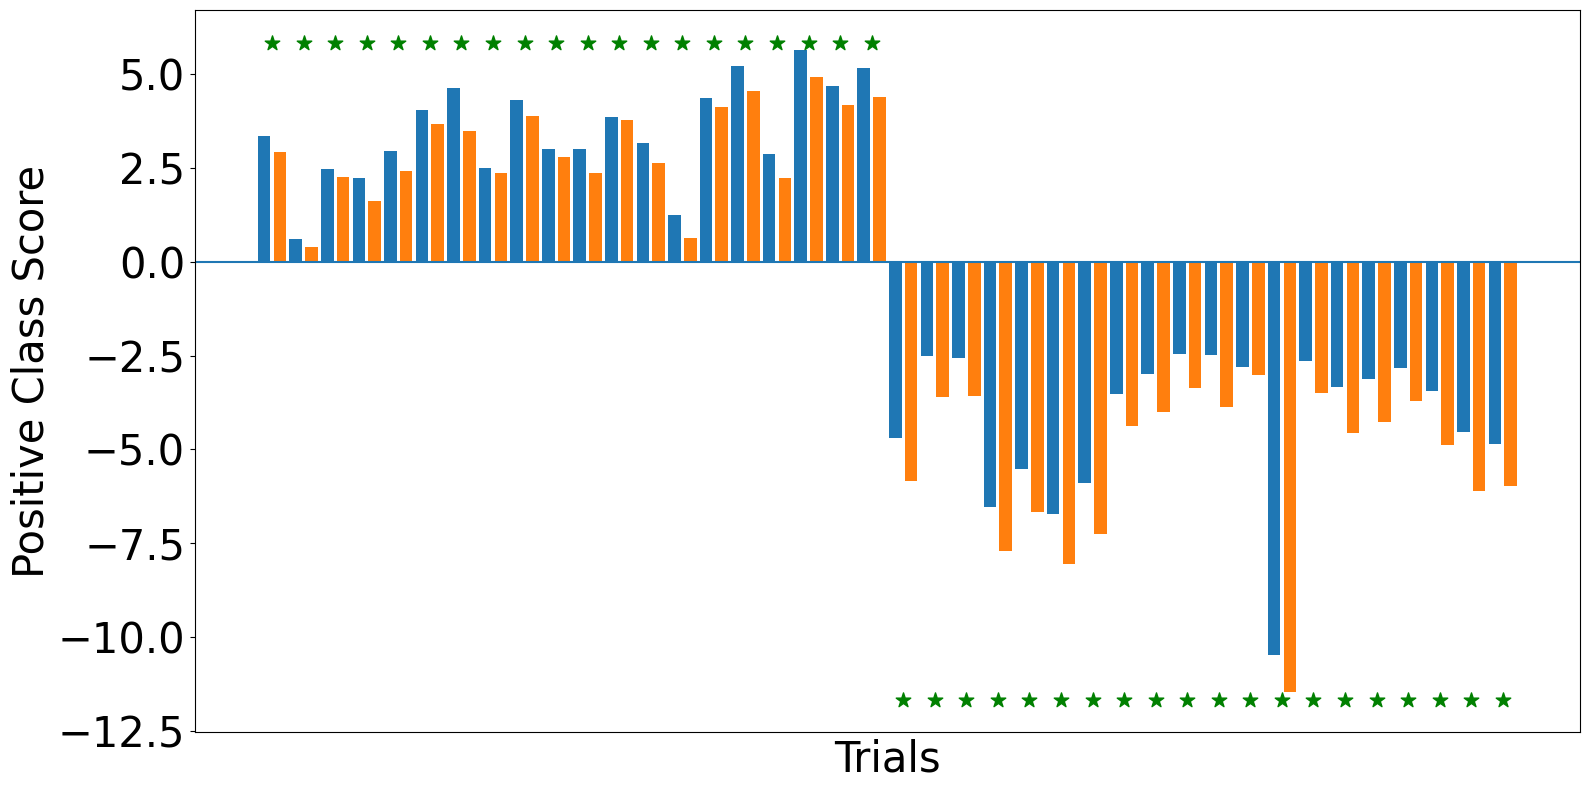

Sbj: 4


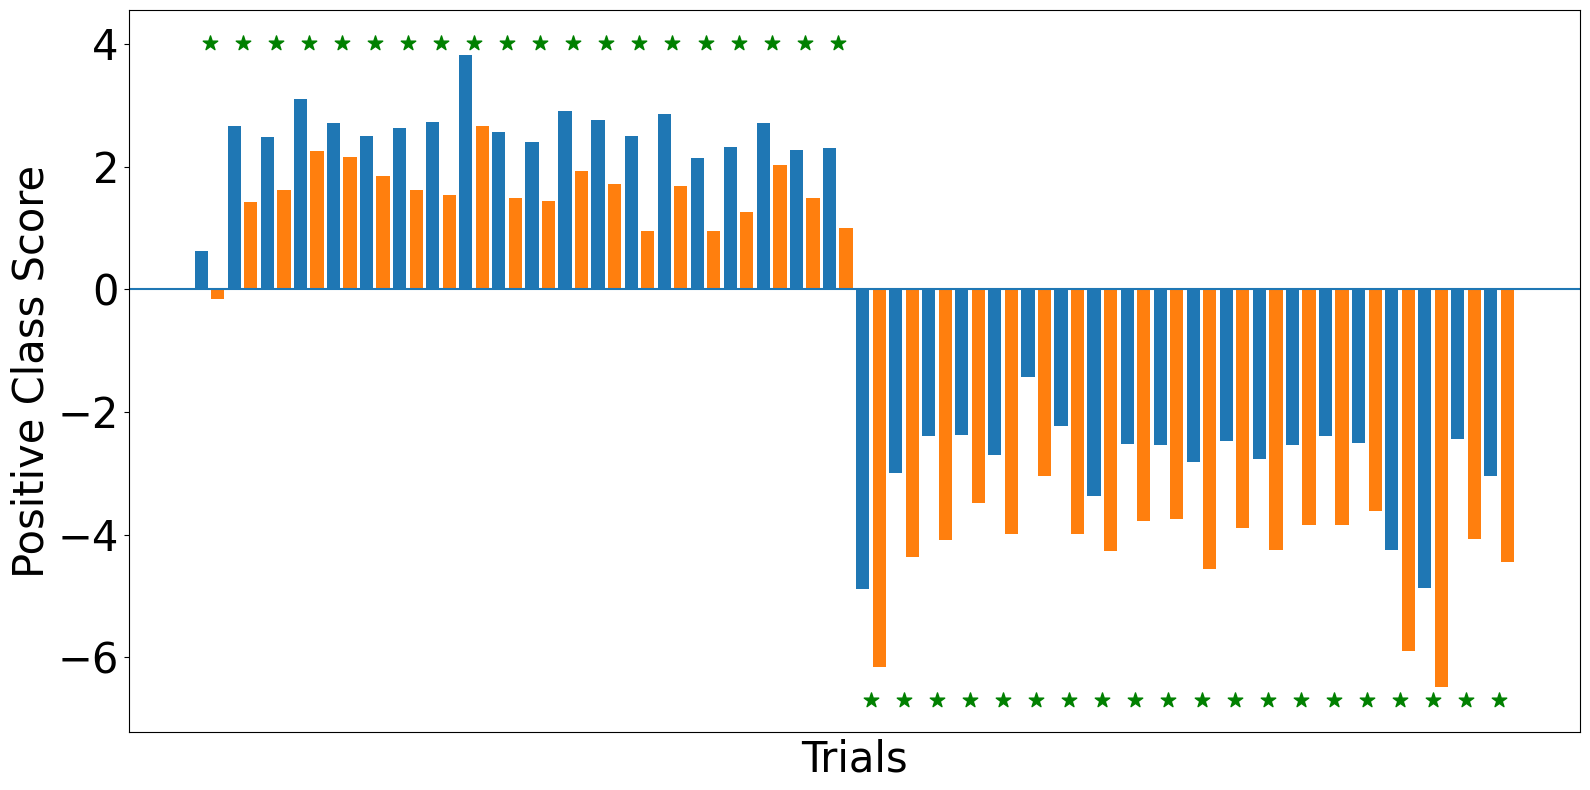

Sbj: 5


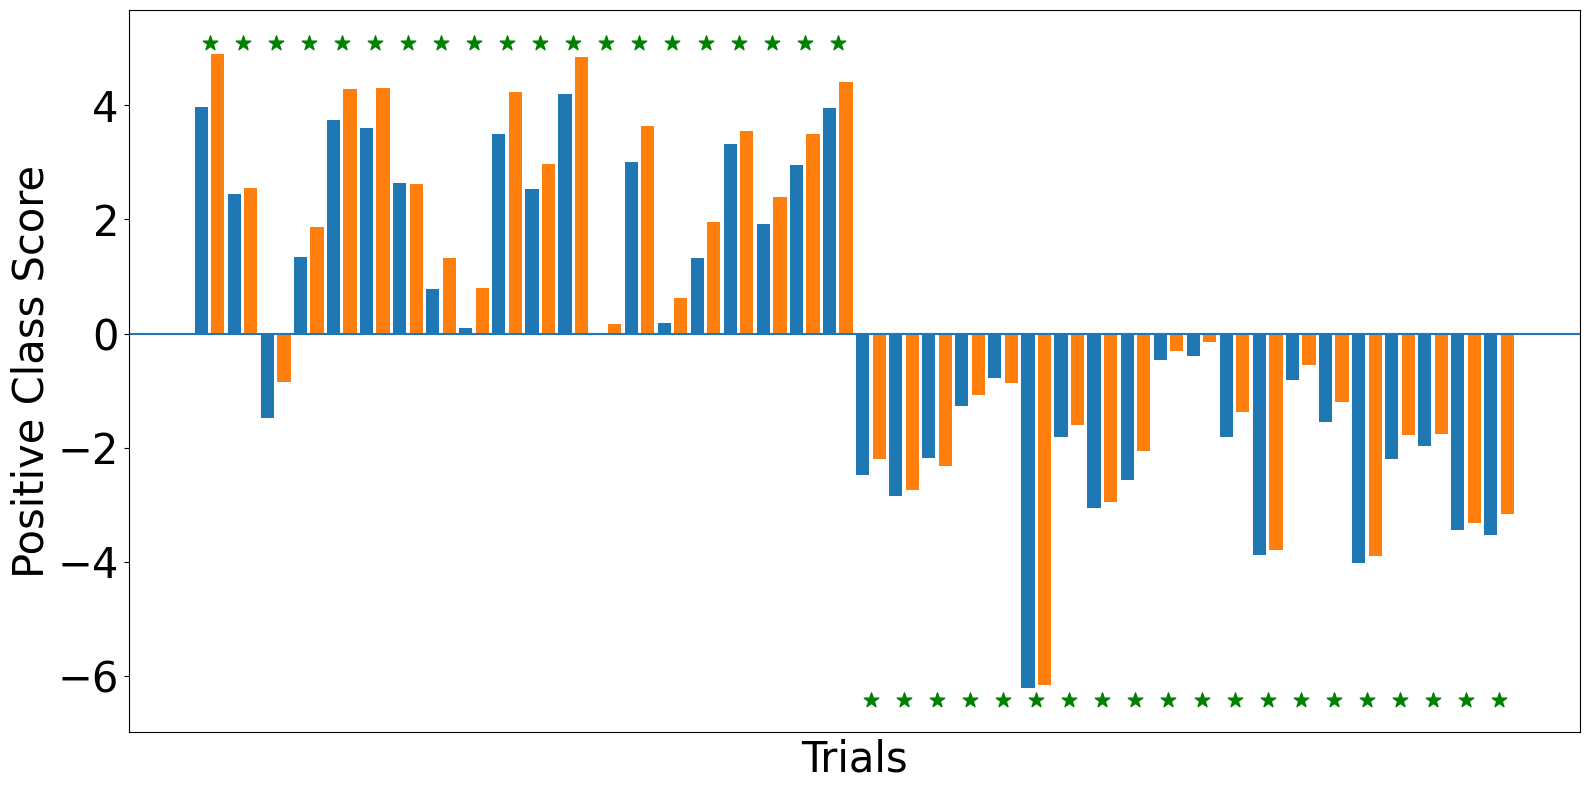

Sbj: 6


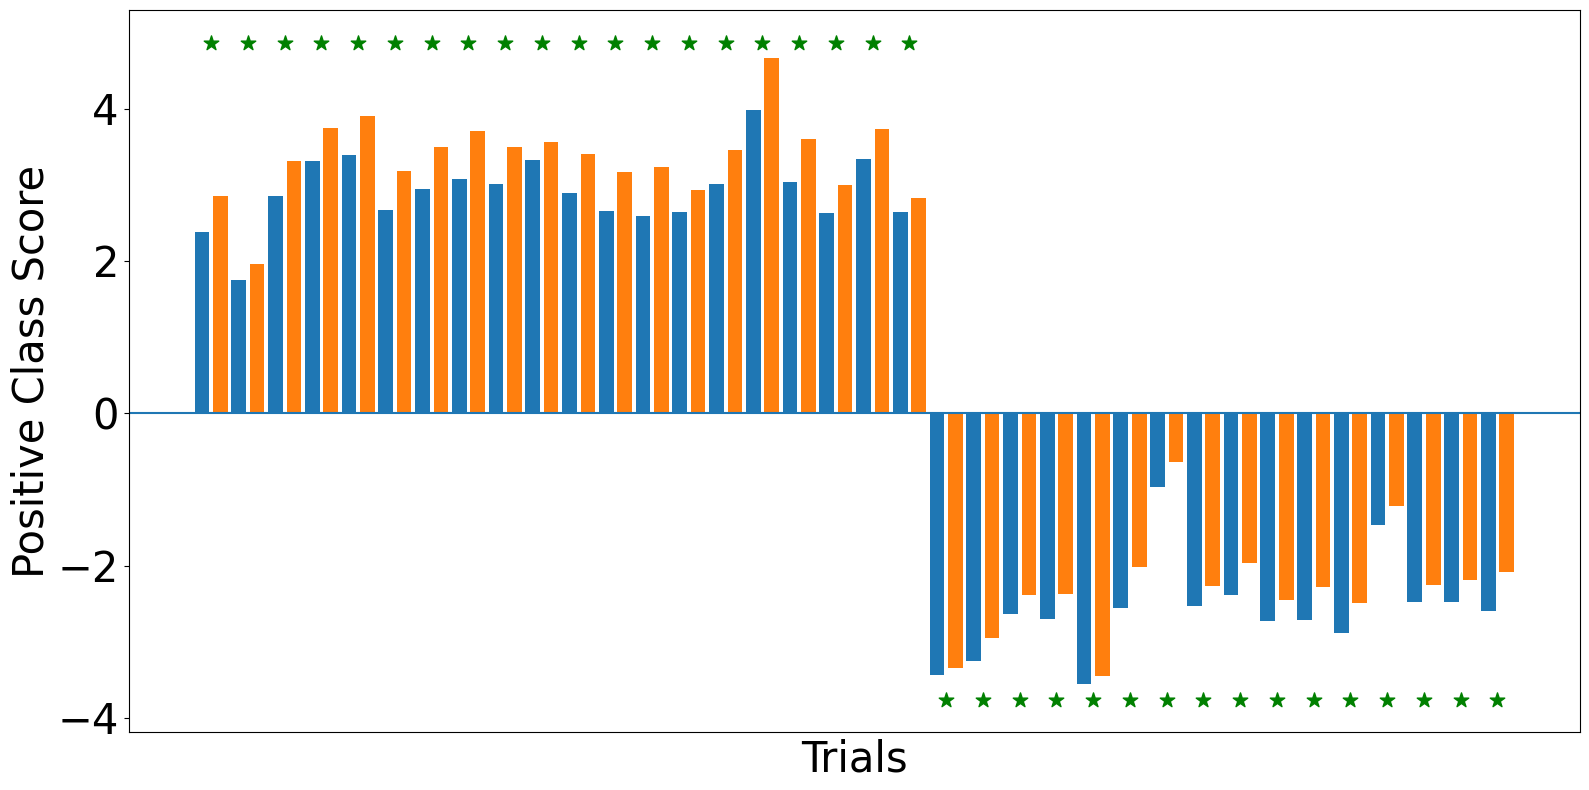

Sbj: 7


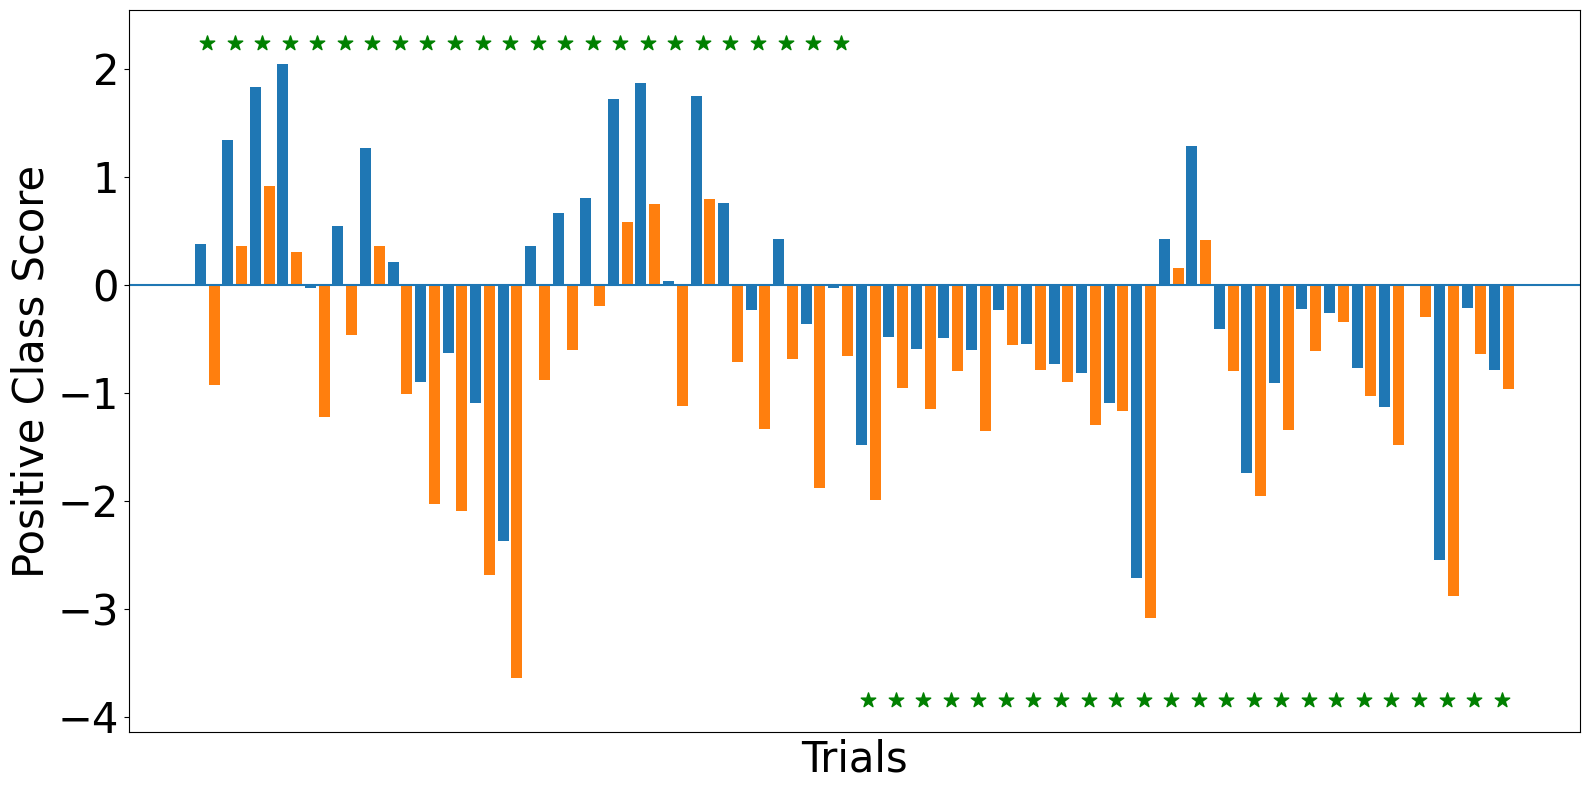

Sbj: 8


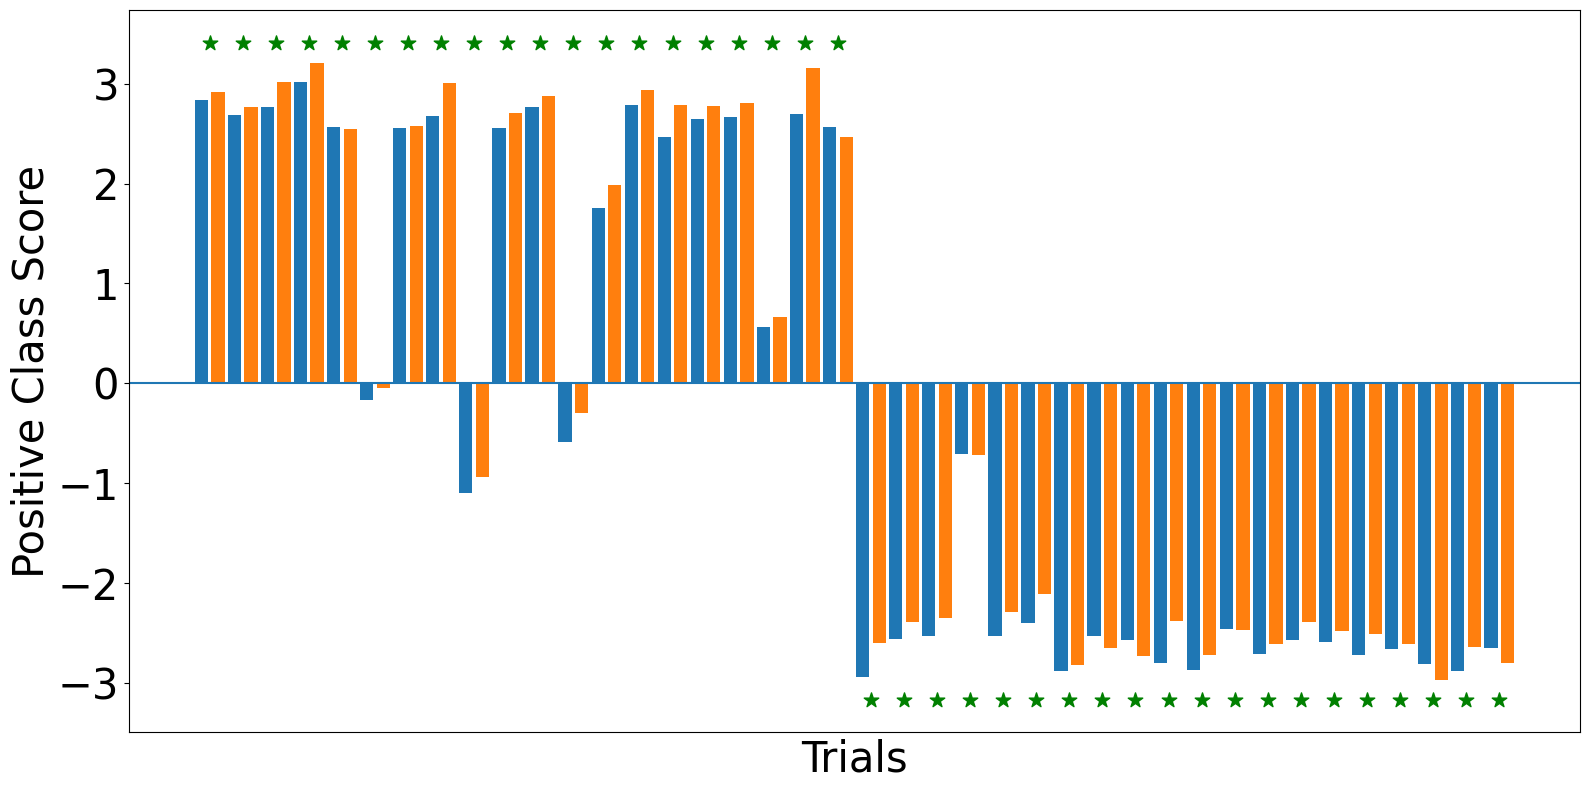

Sbj: 9


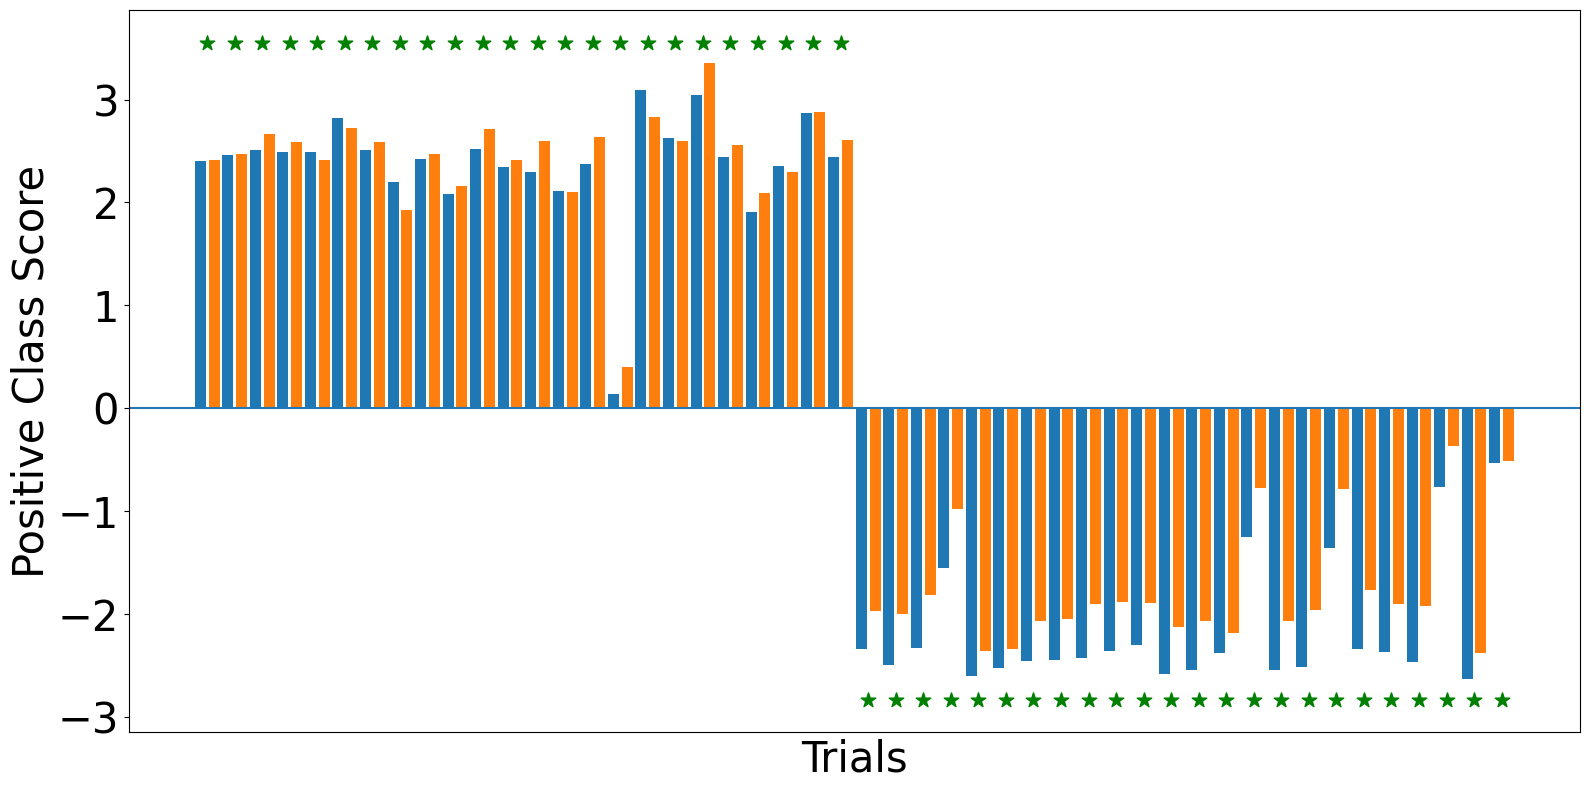

Sbj: 10


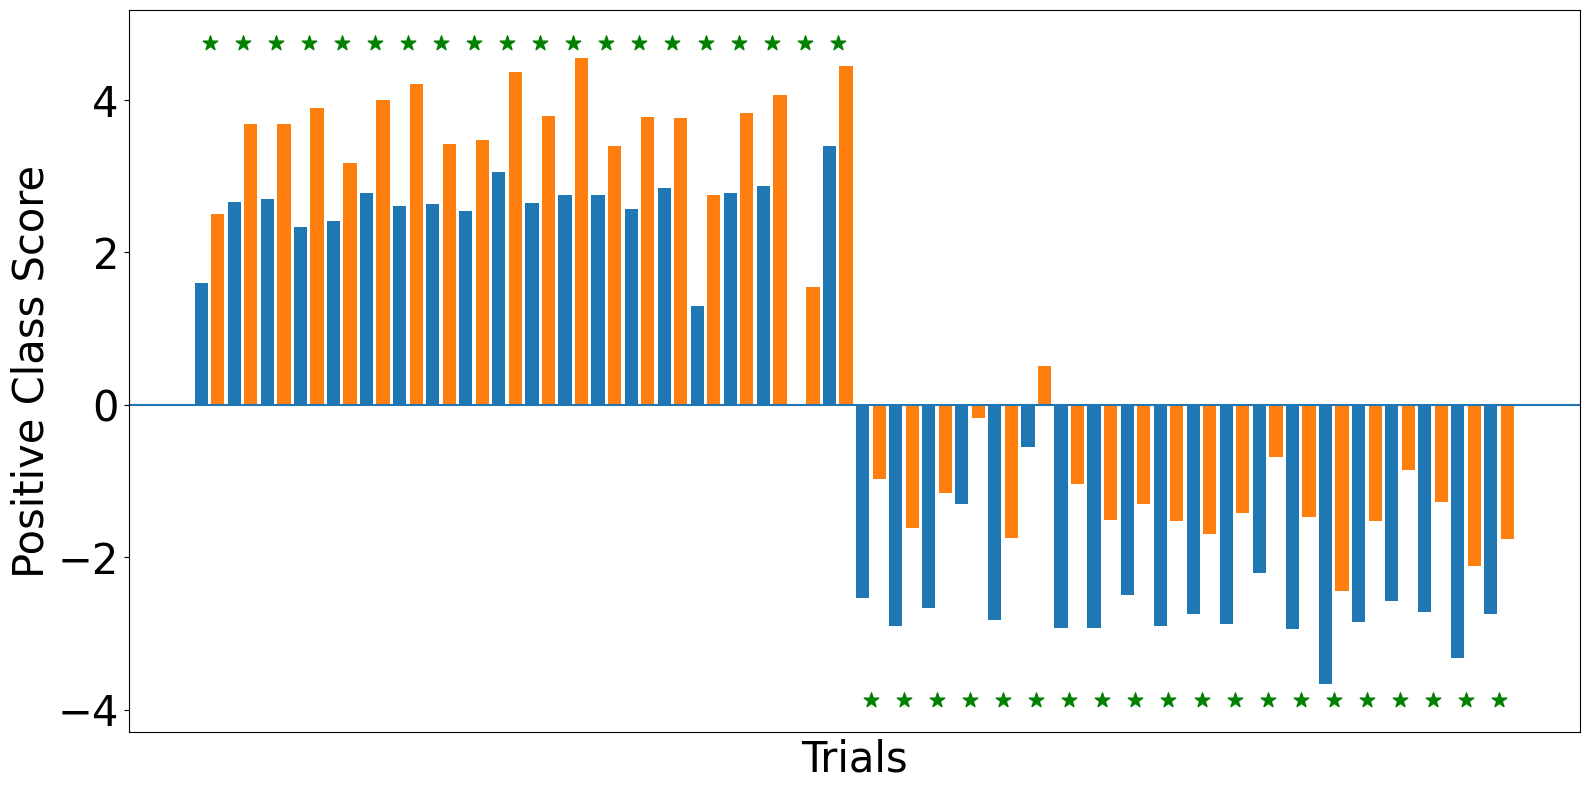

Sbj: 11


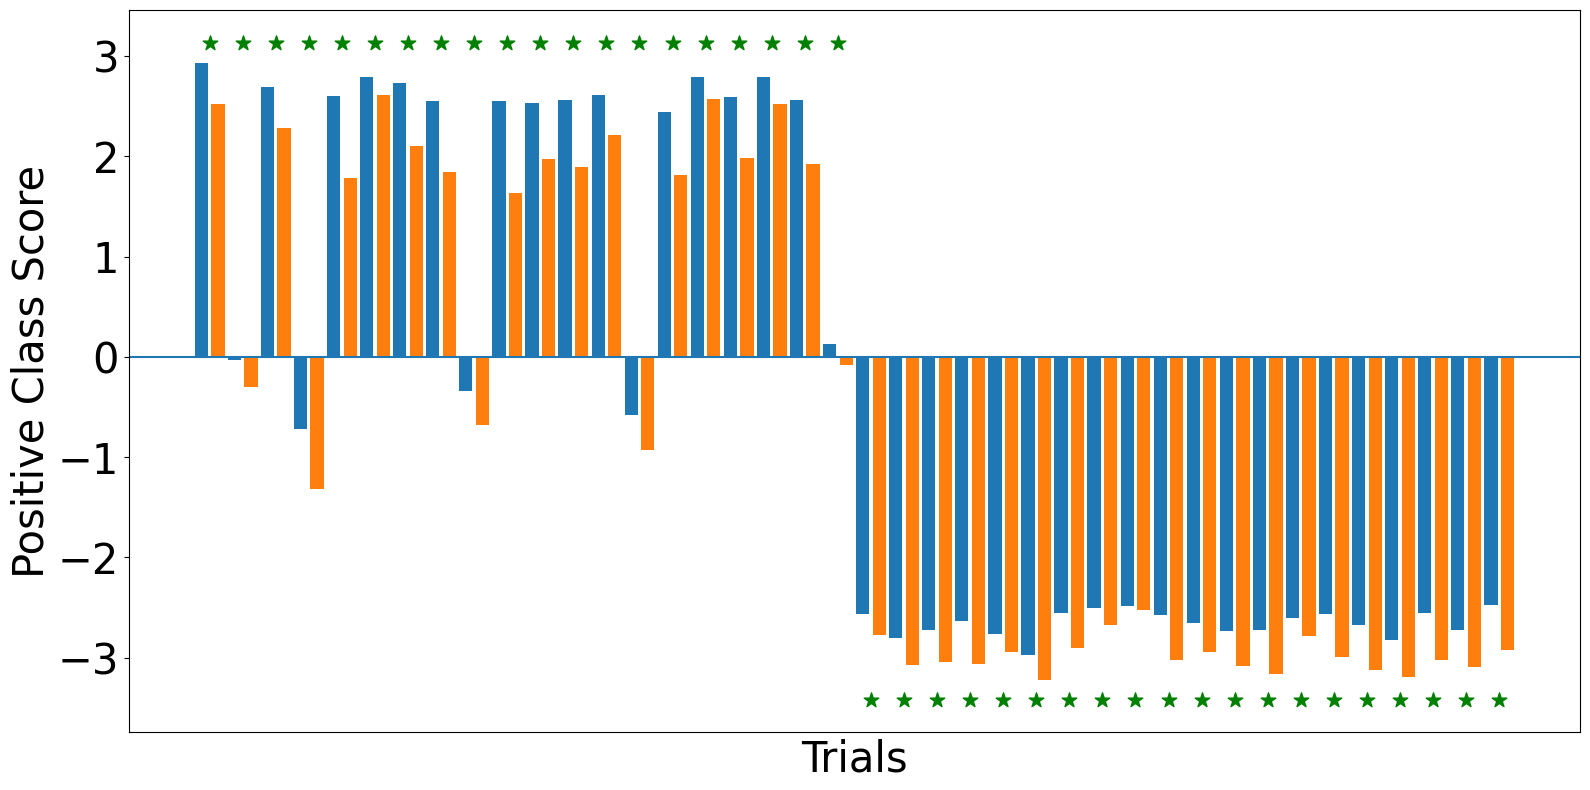

Sbj: 12


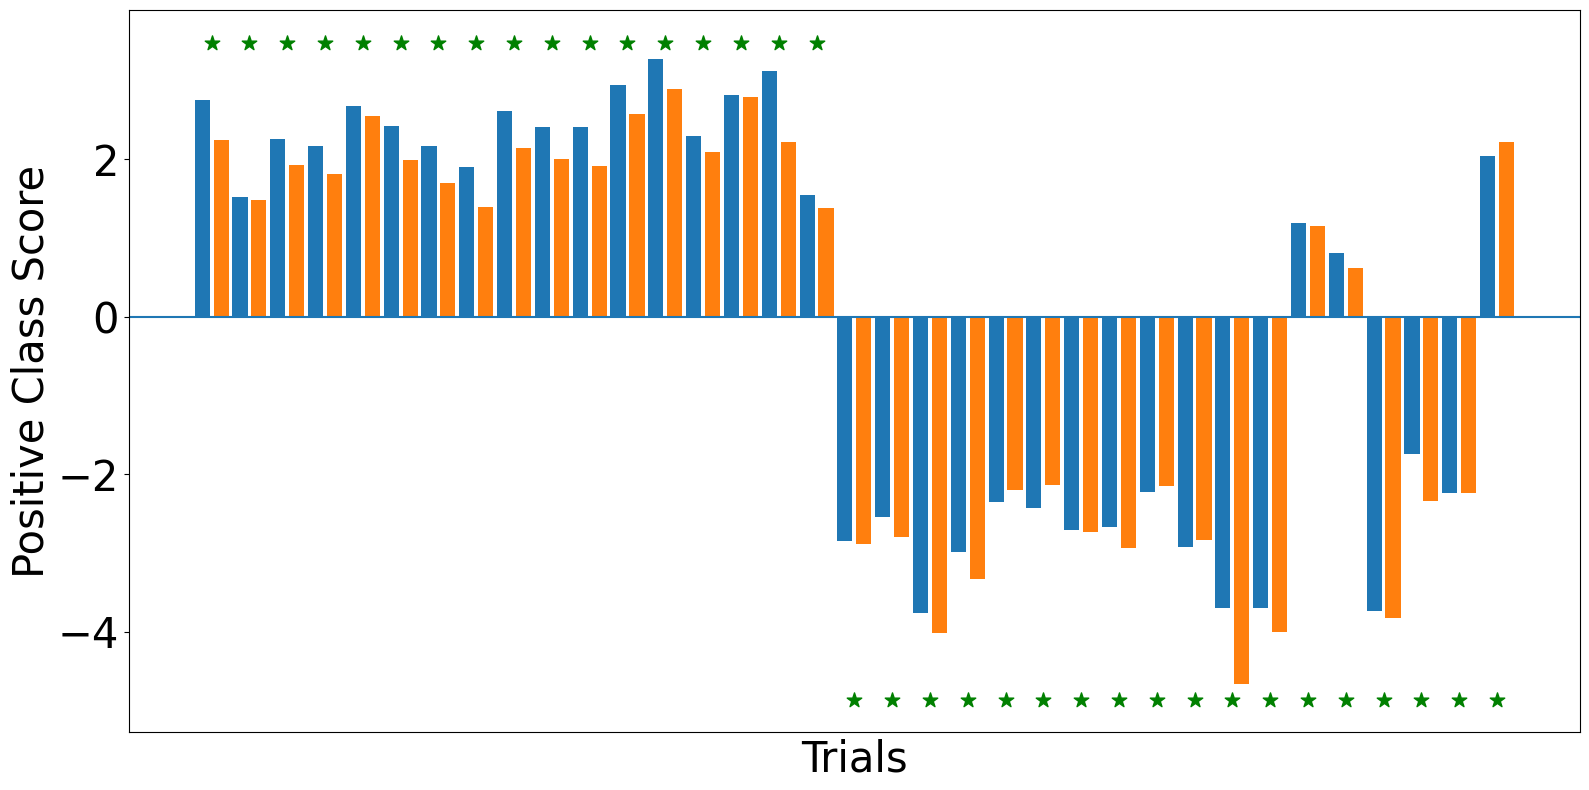

Sbj: 13


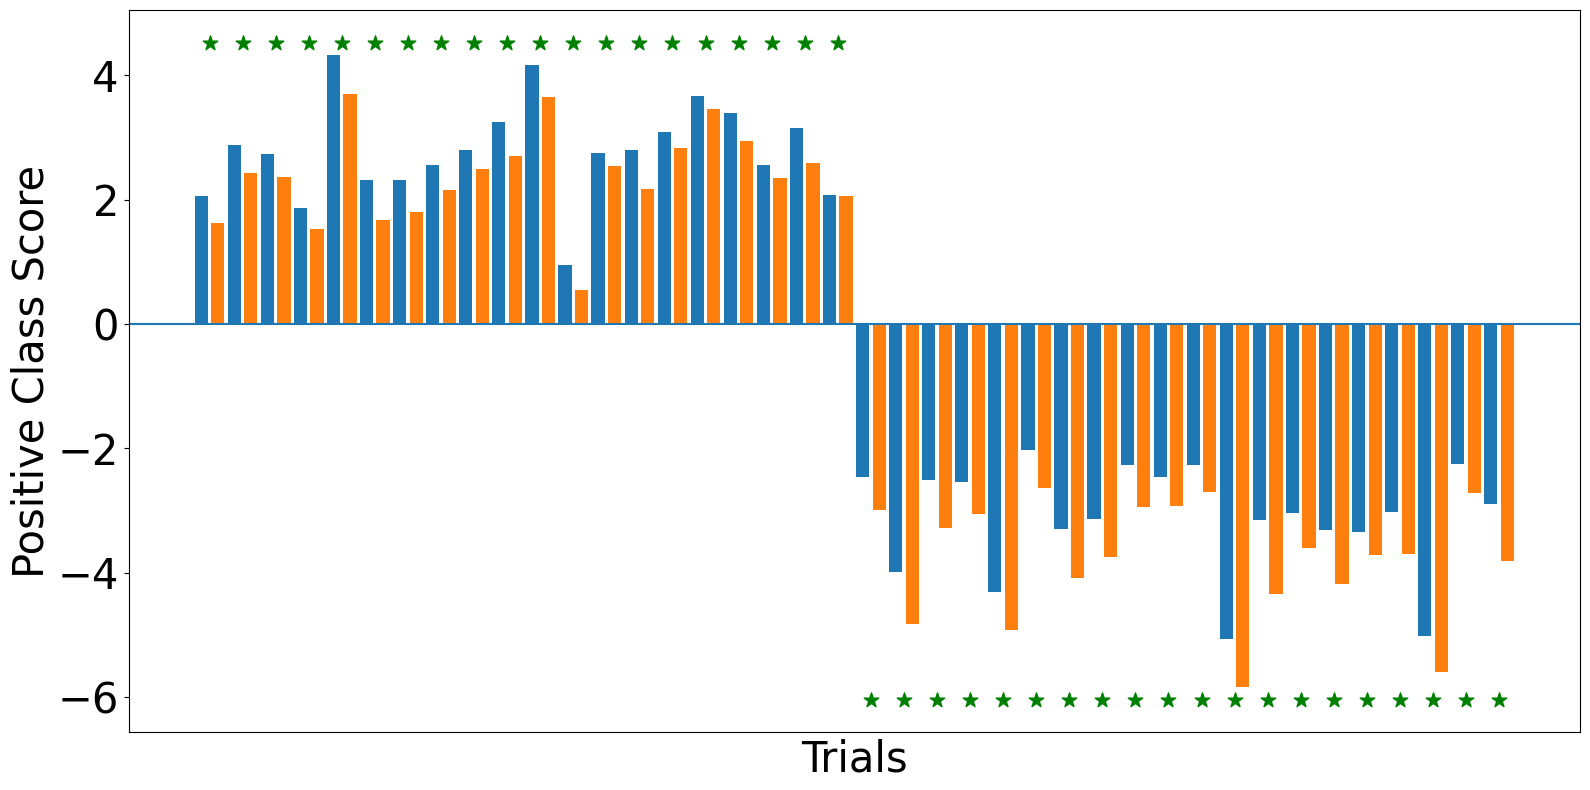

Sbj: 14


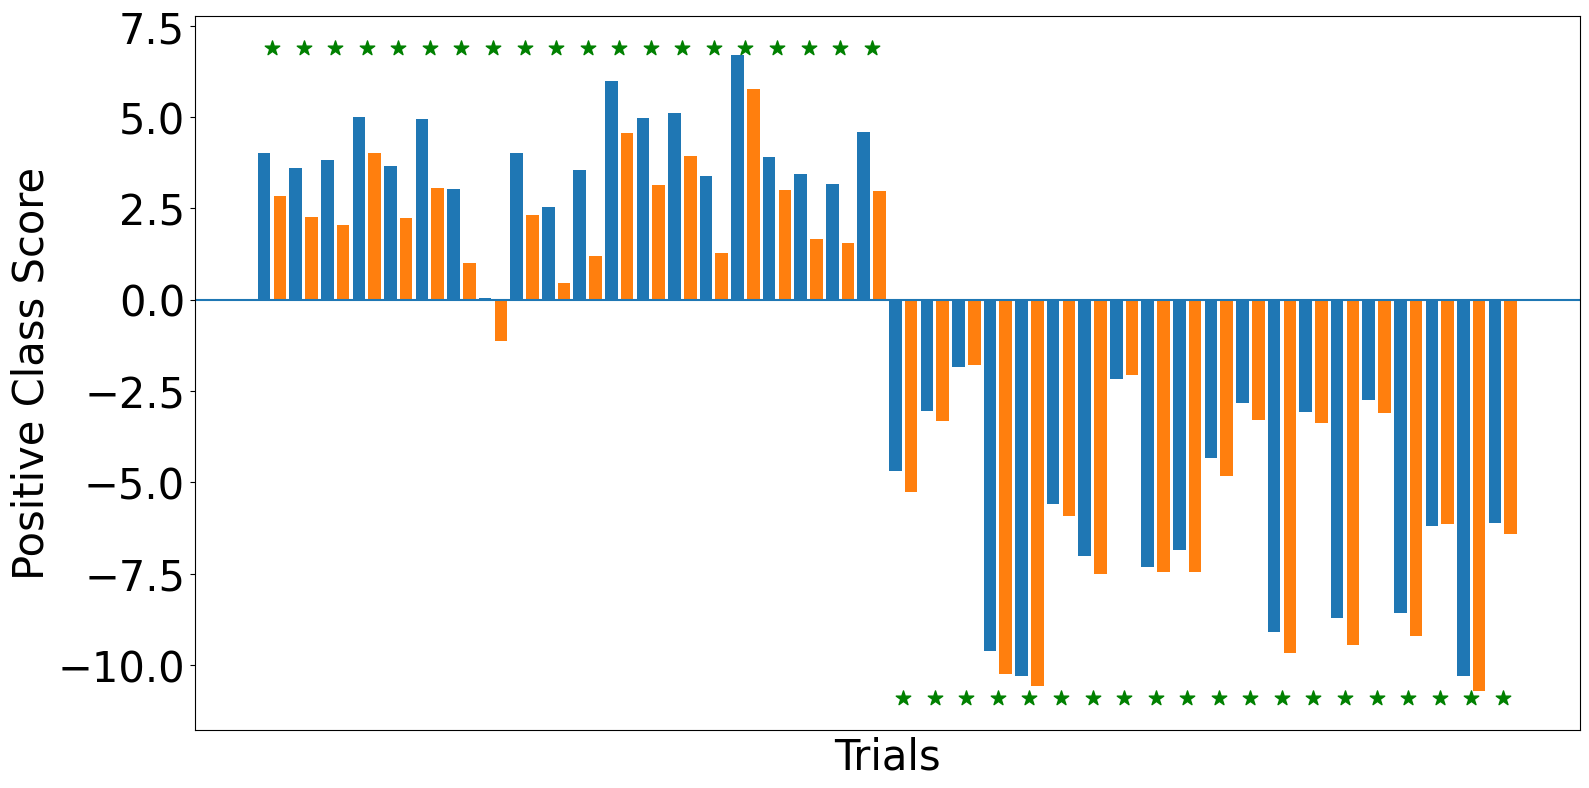

Sbj: 15


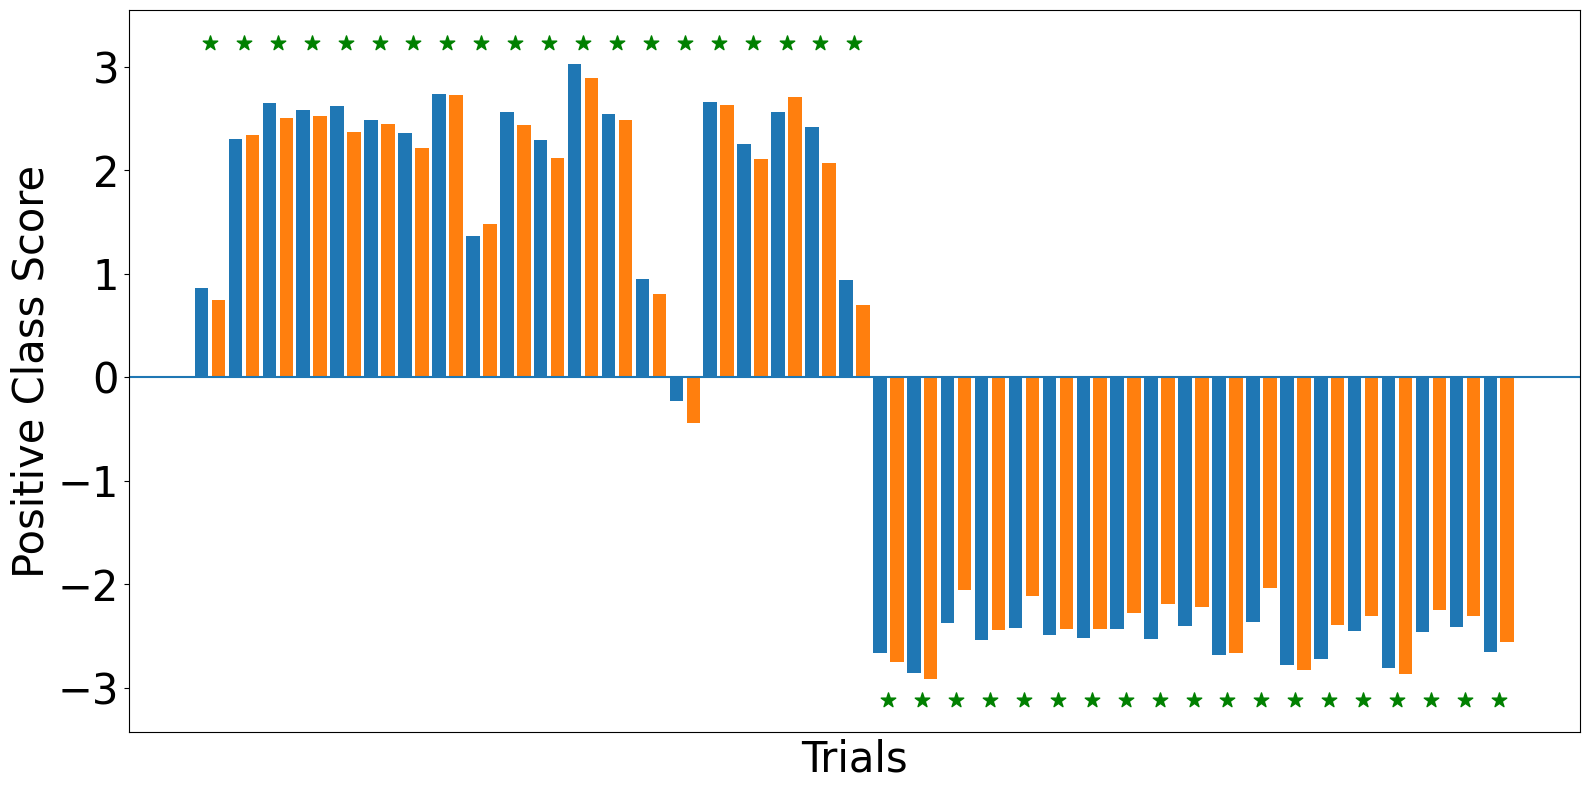

Sbj: 16


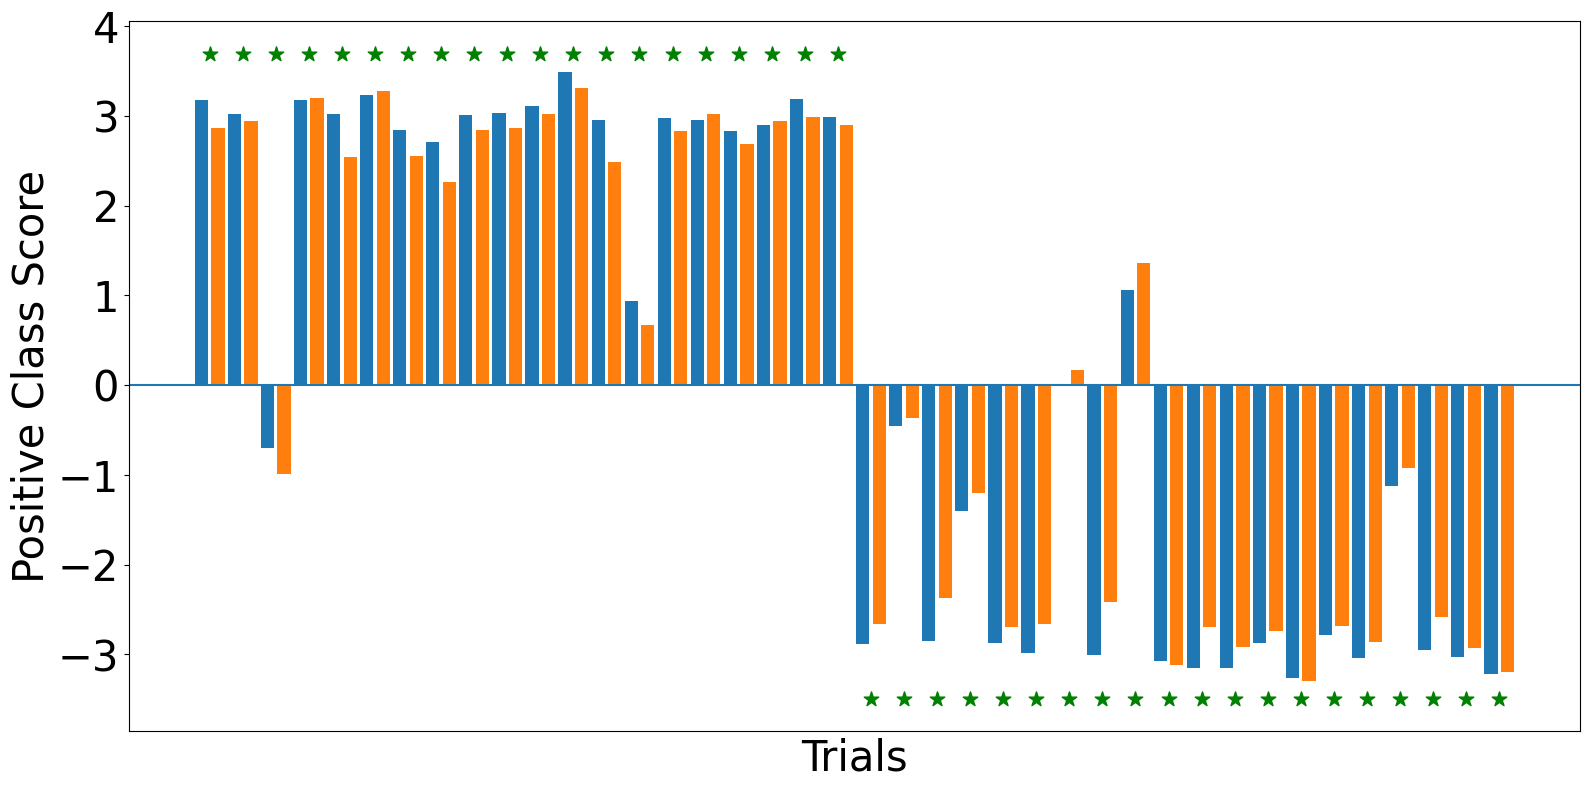

Sbj: 17


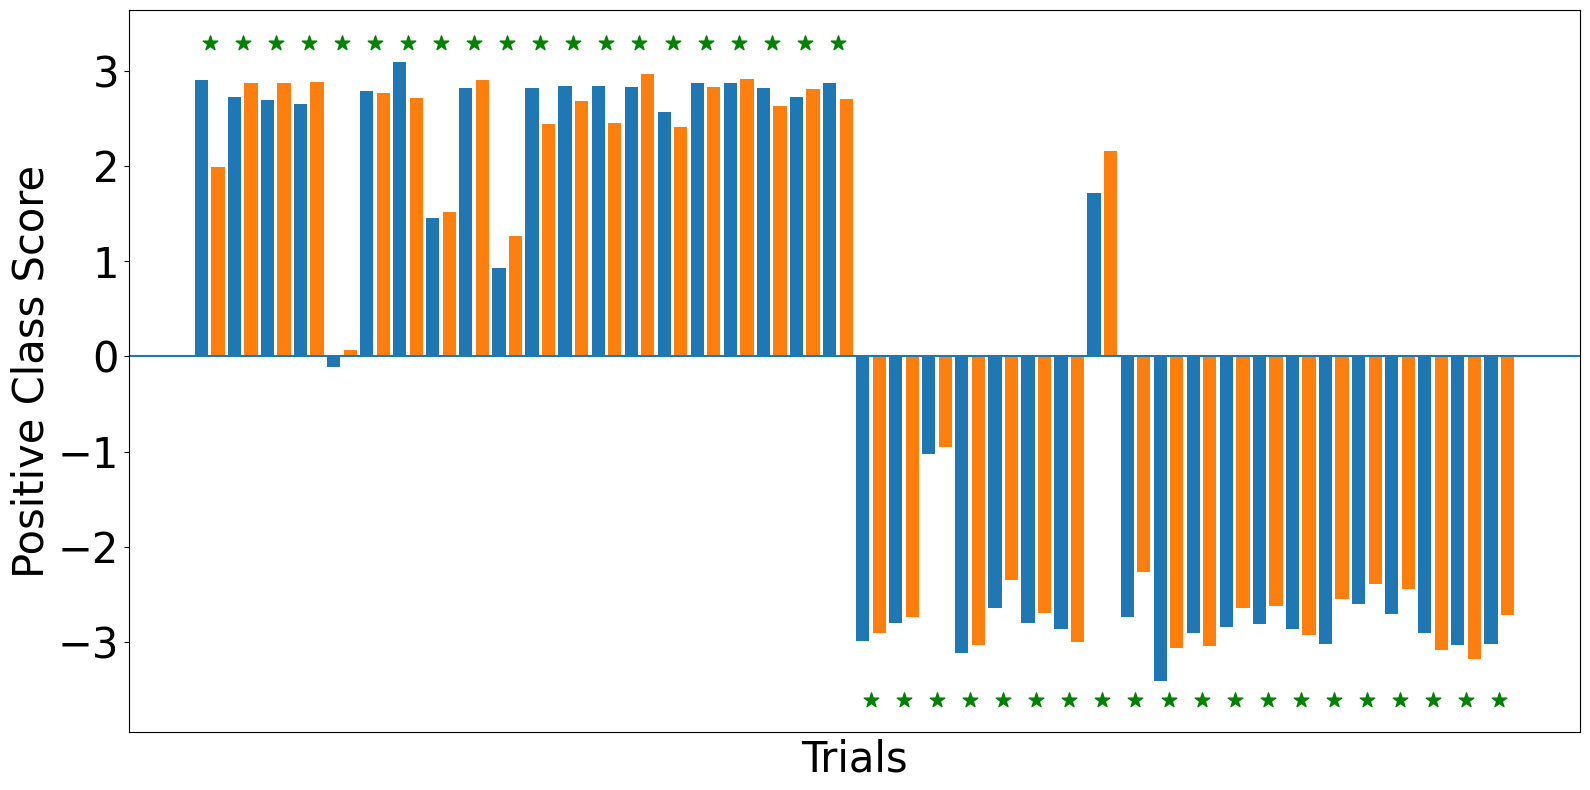

Sbj: 18


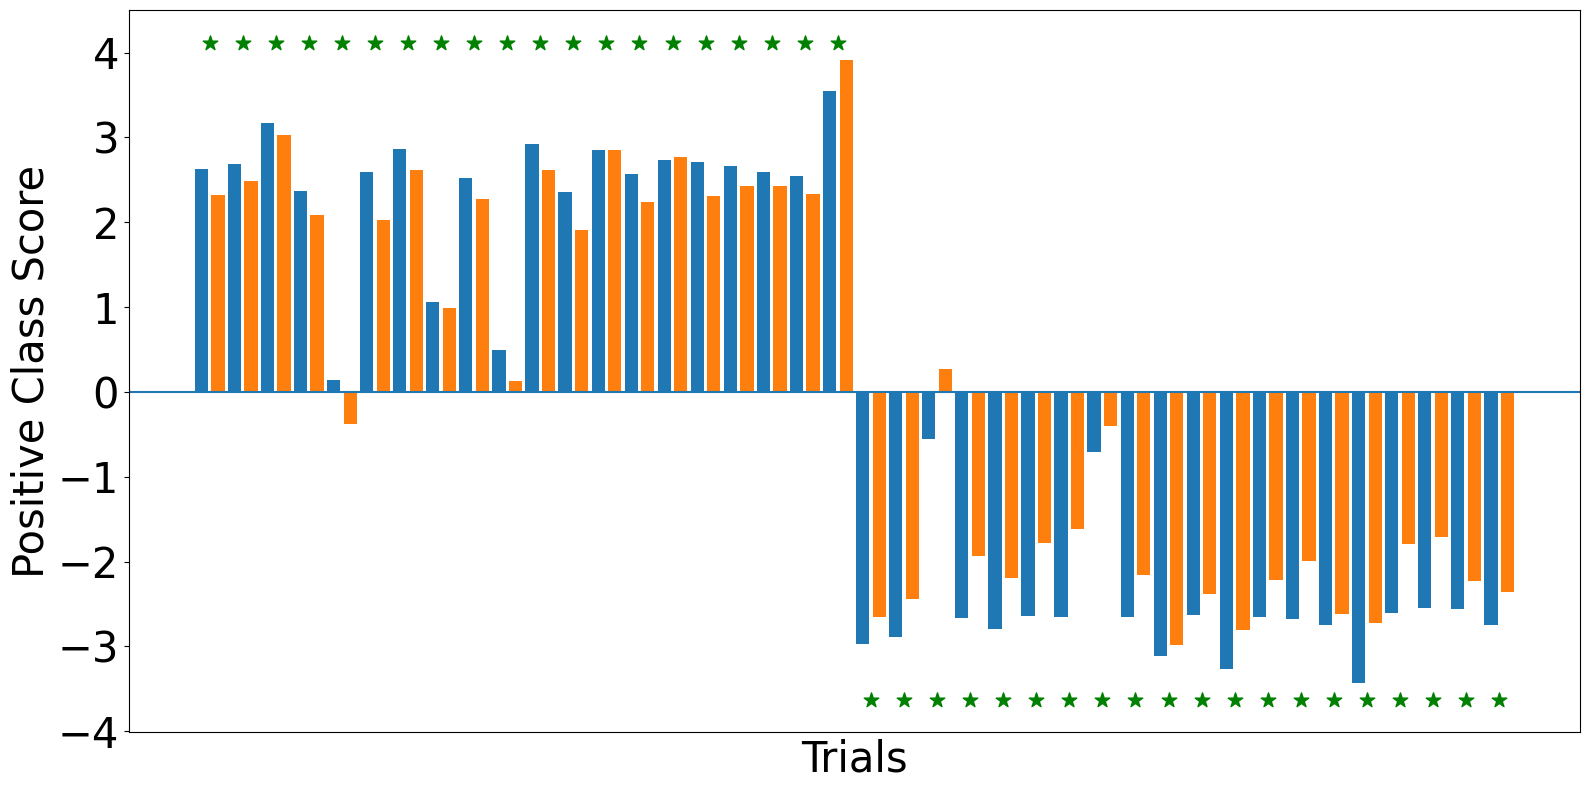

Sbj: 19


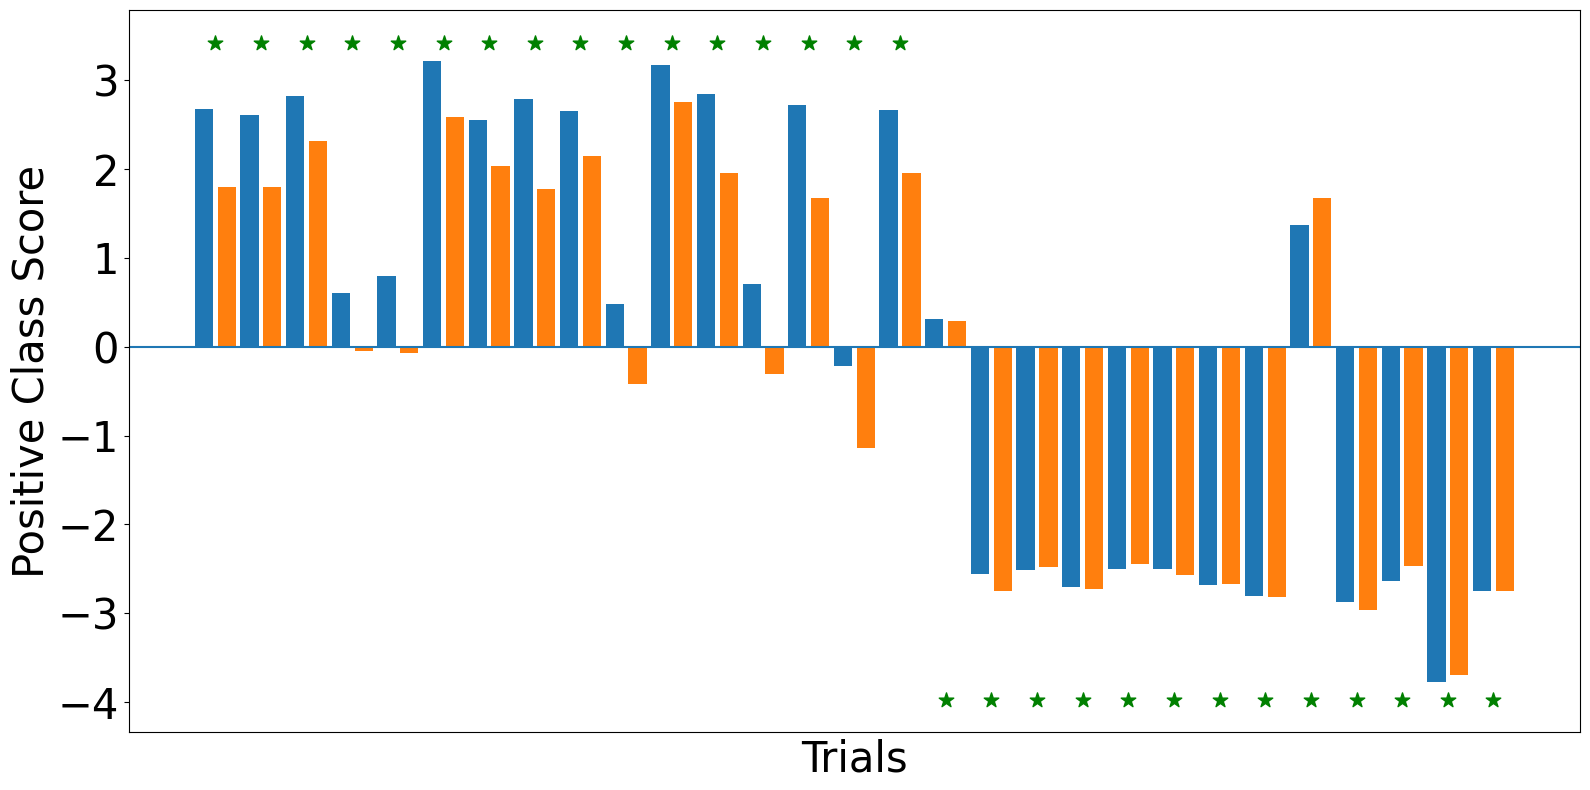

Sbj: 20


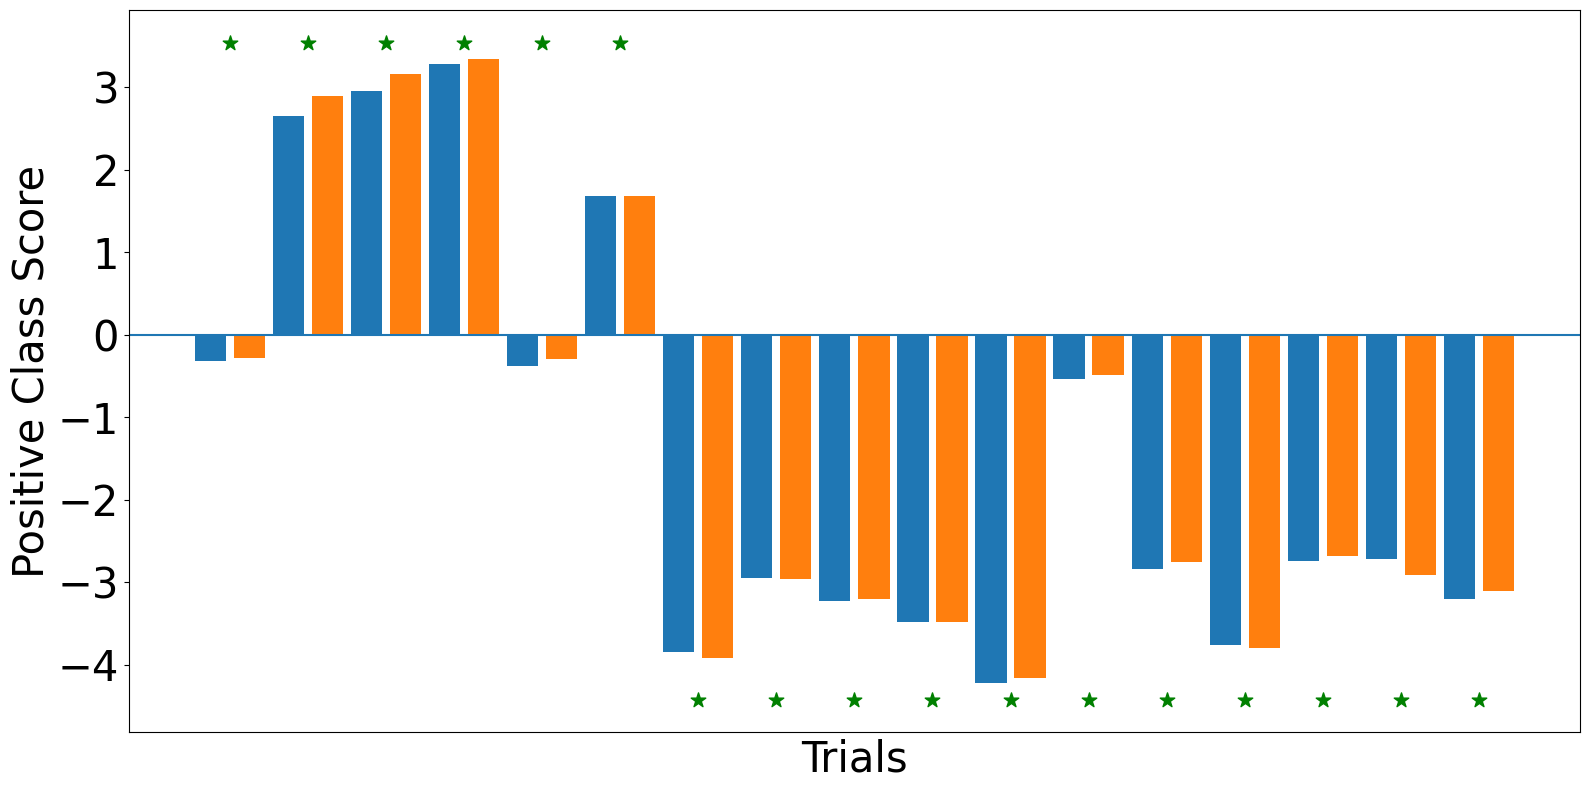

Sbj: 21


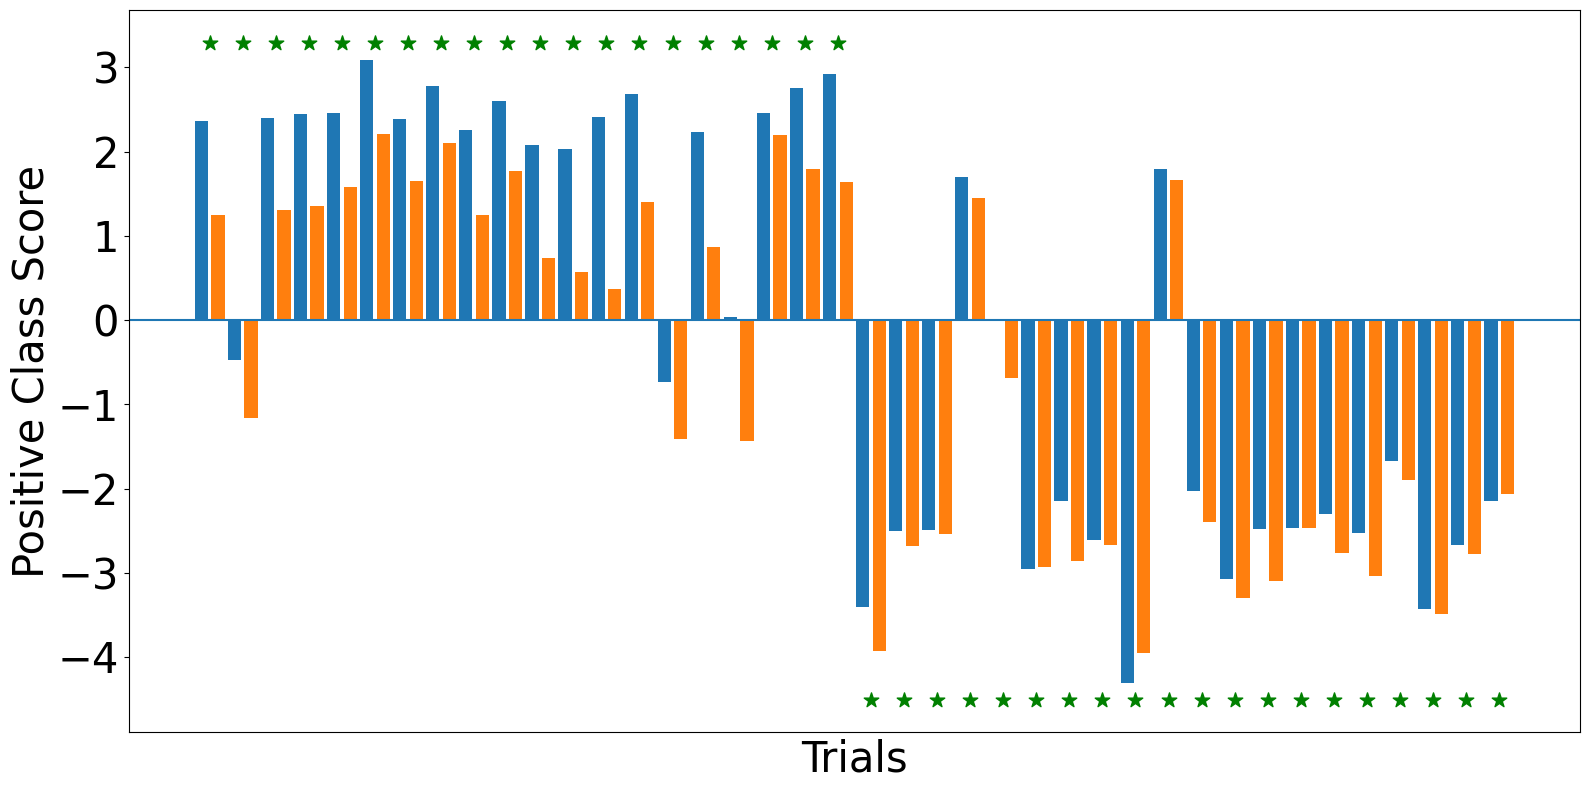

Sbj: 22


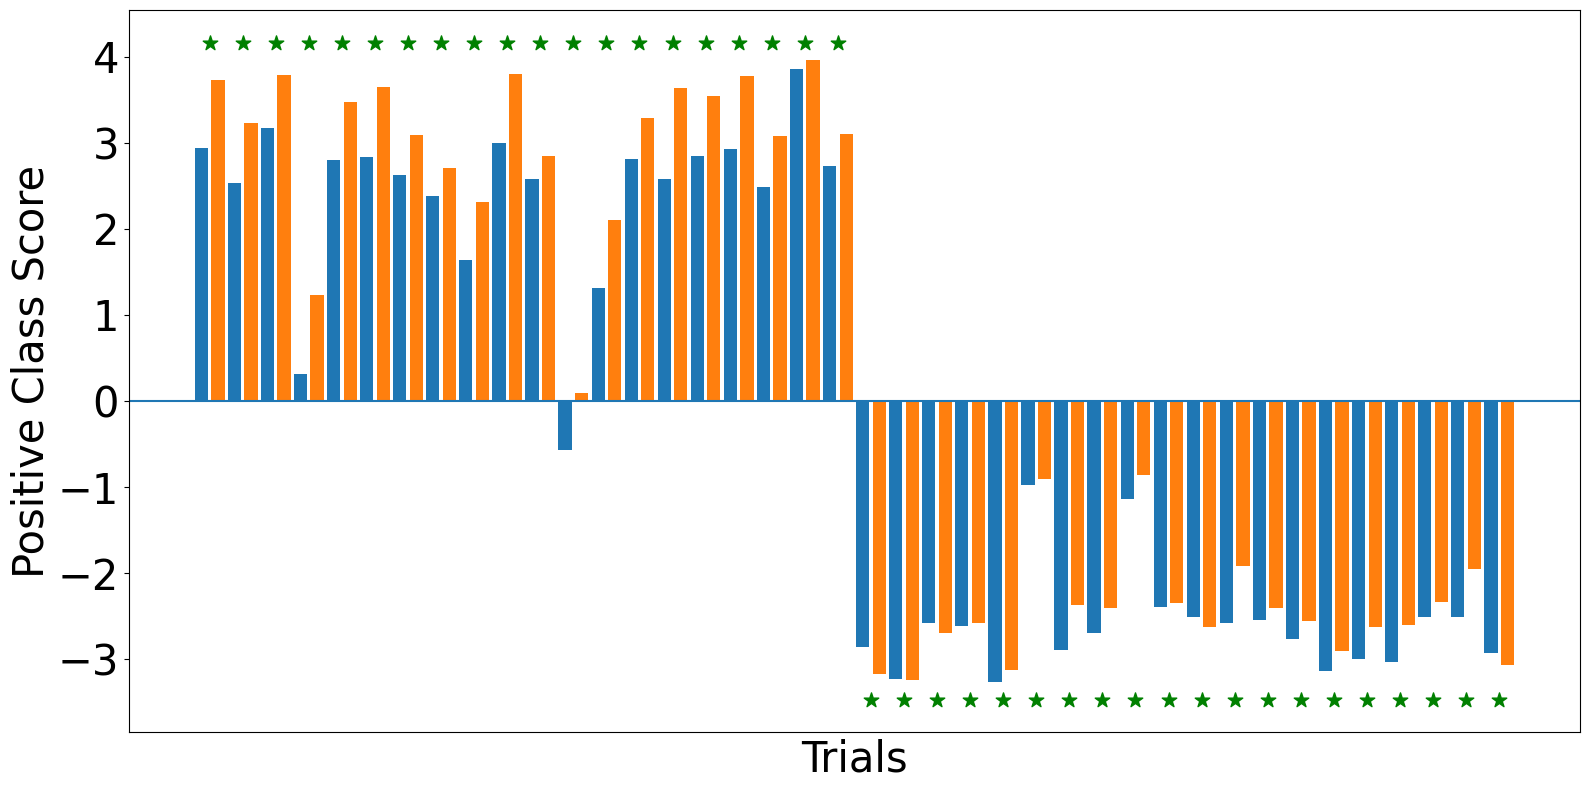

Sbj: 23


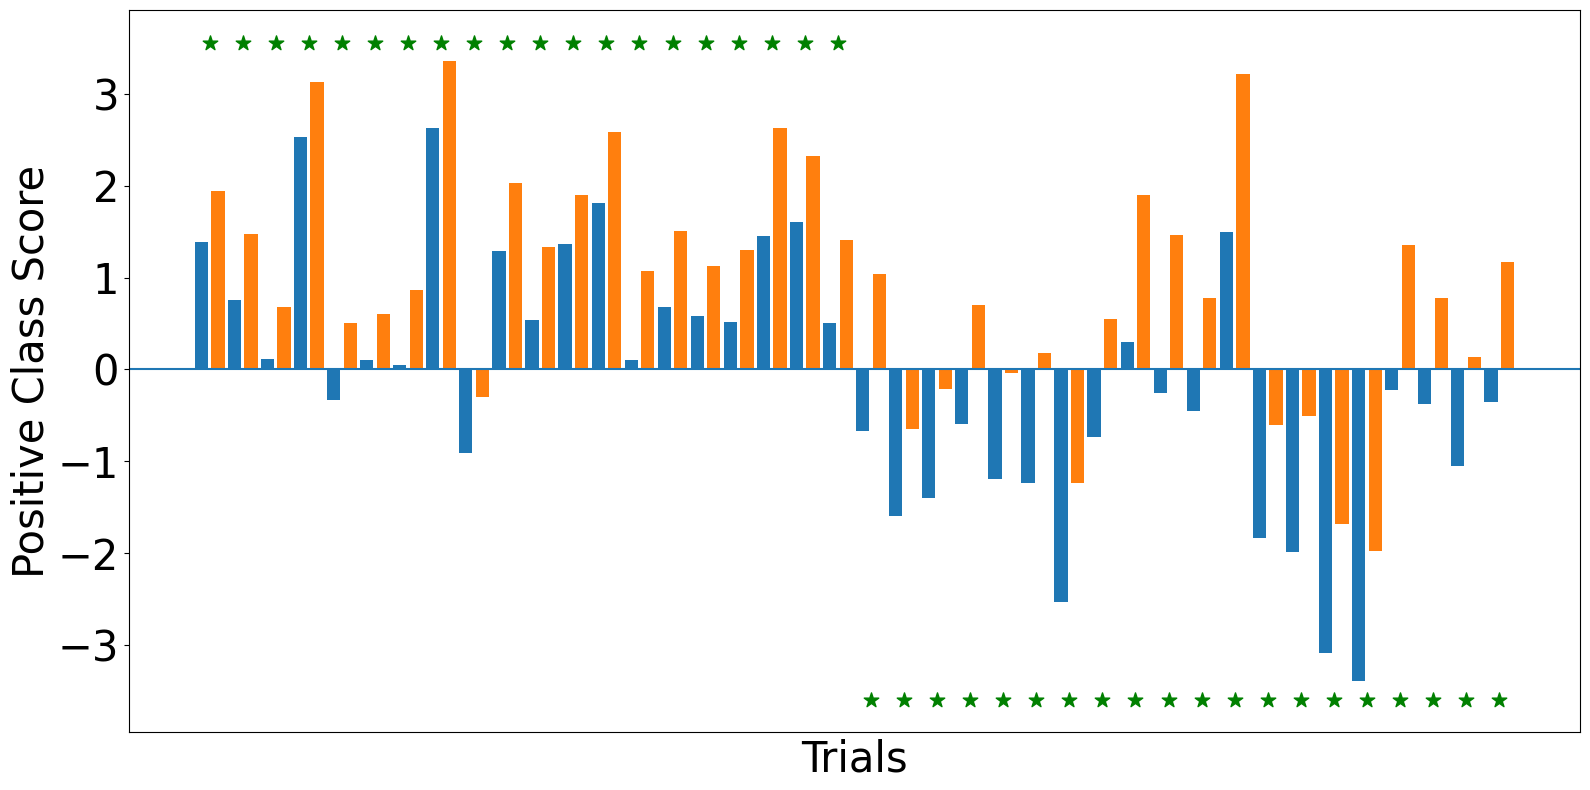

Sbj: 24


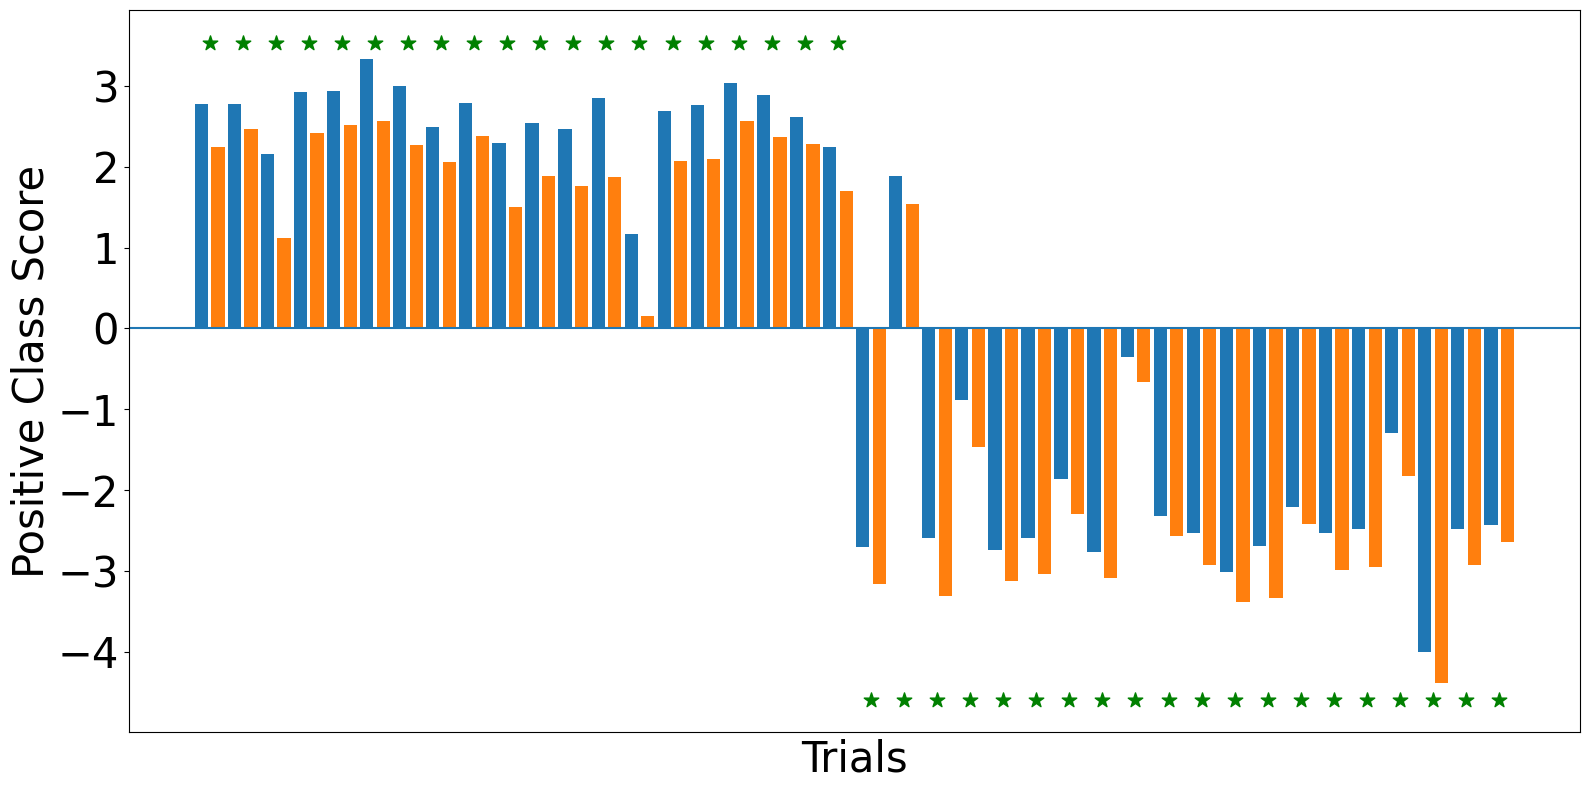

Sbj: 25


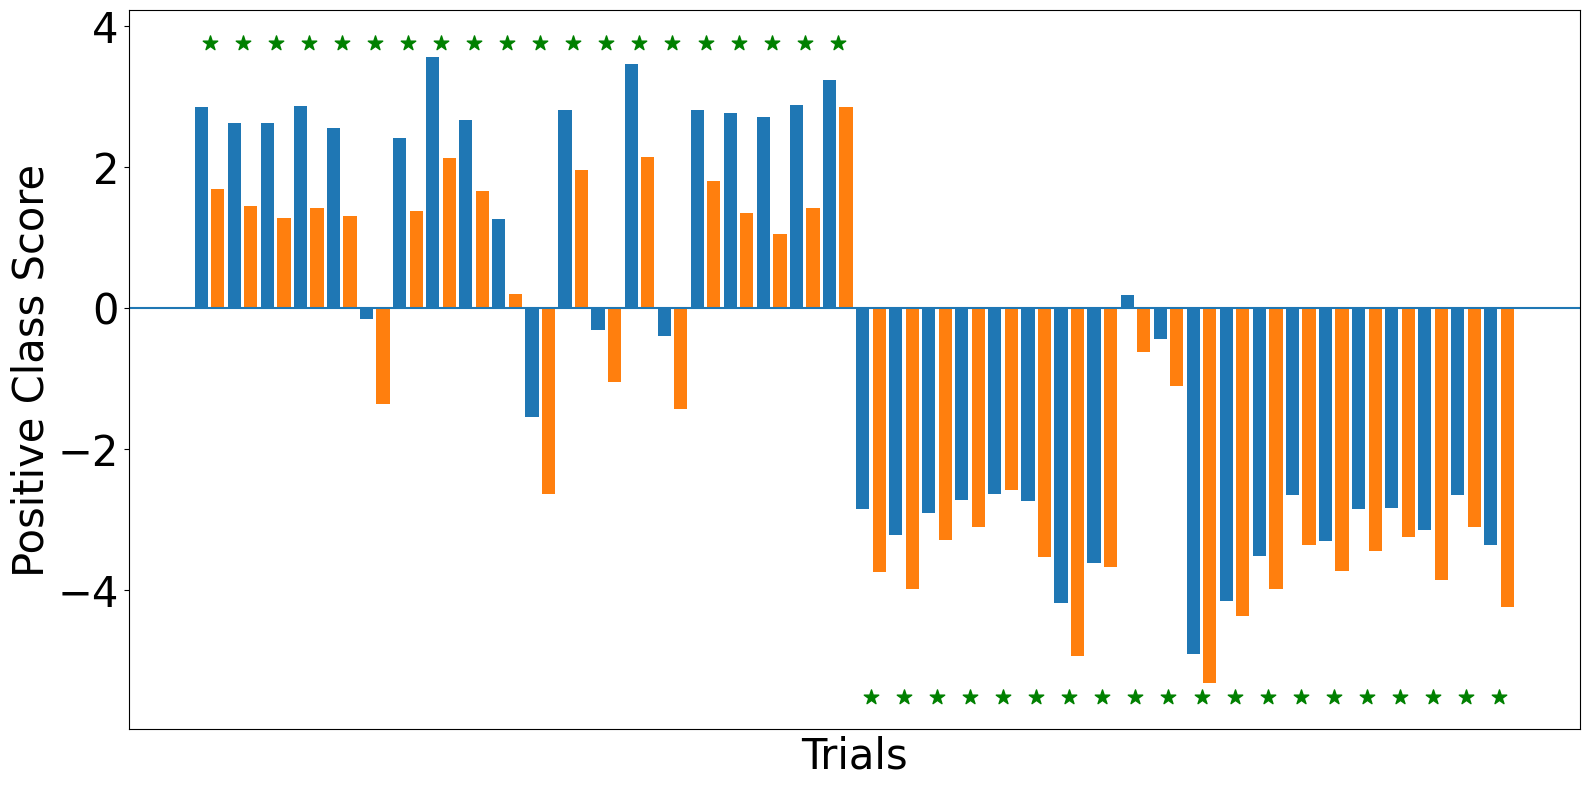

Sbj: 26


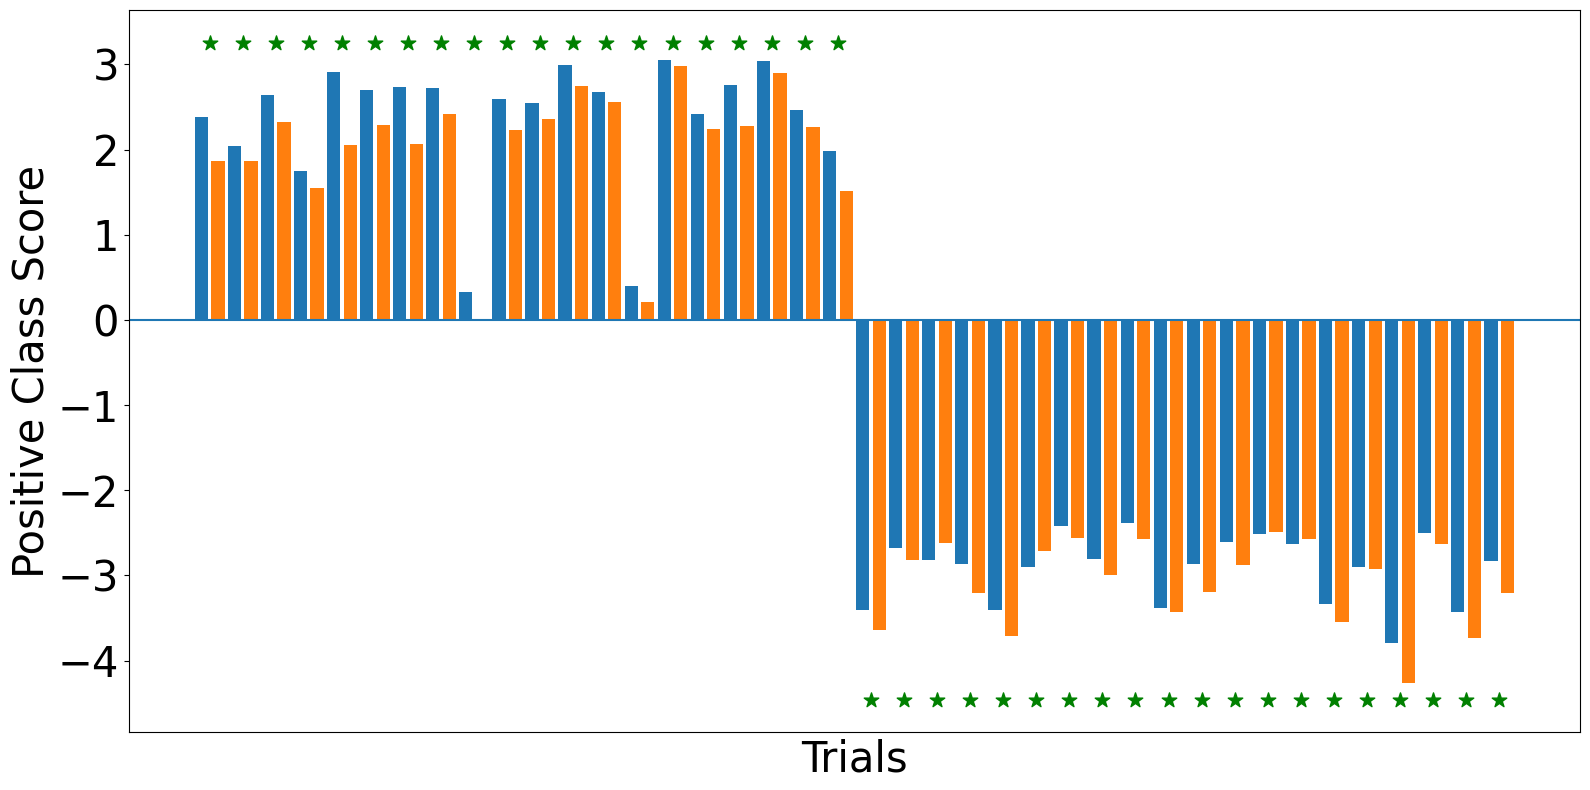

Sbj: 27


KeyboardInterrupt: 

<Figure size 1600x800 with 0 Axes>

In [30]:
average_drop = []
average_gain = []
std_drop = []
std_gain = []

def multi_sort(*args, reverse=True):
    sorted_lists = (list(t) for t in zip(*sorted(zip(*args), reverse=reverse)))
    return tuple(sorted_lists)

for sbj, data in cam.items():
    print(f'Sbj: {sbj}')
    signals = data[3][0,...,0]
    val_index = data[7]
    baseline = data[4][val_index]
    drop = data[5][val_index]
    
    length = baseline.shape[0]
    ground_truth = np.array(data[1])[val_index]
    
    ground_truth, new_order = multi_sort(ground_truth, np.arange(baseline.shape[0]), reverse=False)
    ground_truth = np.array(ground_truth)
    baseline = baseline[new_order]
    drop = drop[new_order]
    
    difference = (drop-baseline)/np.abs(baseline)
    
    max_bar_0 = np.max(np.append(baseline[:,0], drop[:,0]))
    min_bar_0 = np.min(np.append(baseline[:,0], drop[:,0]))
    max_bar_1 = np.max(np.append(baseline[:,1], drop[:,1]))
    min_bar_1 = np.min(np.append(baseline[:,1], drop[:,1]))
    ground_truth_0 = []
    ground_truth_1 = []
    for i in ground_truth:
        if i == 0:
            ground_truth_0 += [max_bar_0+0.2]
            ground_truth_1 += [min_bar_1-0.2]
        else:
            ground_truth_1 += [max_bar_1+0.2]
            ground_truth_0 += [min_bar_0-0.2]
    fig, ax = plt.subplot_mosaic([['r']], figsize=(16, 8))
    #fig.suptitle(f'Sbj{sbj} Gain/Drop')

    ax['r'].set_ylabel(f'Positive Class Score', size=30)
    ax['r'].bar(np.arange(len(val_index)) - 0.25, baseline[:,0], label='Sparse Output', width=0.4)
    ax['r'].bar(np.arange(len(val_index)) + 0.25, drop[:,0], label='Output + Drop/Gain', width=0.4)
    ax['r'].scatter(np.arange(len(val_index)), ground_truth_0, marker='*', c='green', s=120, label='Ground Truth')
    ax['r'].axhline(0)
    ax['r'].set_xlabel(f'Trials', size=30)
    plt.yticks(fontsize=30)
    plt.xticks([])
    
    fig.tight_layout()
    
    plt.savefig(f'./gains/Sbj{sbj} Gain.pdf', bbox_inches='tight')
    
    #plt.ylim(-4.2,6.1)

    plt.show()
    
    average_drop += [[np.mean(difference[np.where(ground_truth==0), 1]), np.mean(difference[np.where(ground_truth==1), 0])]]
    average_gain += [[np.mean(difference[np.where(ground_truth==0), 0]), np.mean(difference[np.where(ground_truth==1), 1])]]
    std_drop += [[np.std(difference[np.where(ground_truth==0), 1]), np.std(difference[np.where(ground_truth==1), 0])]]
    std_gain += [[np.std(difference[np.where(ground_truth==0), 0]), np.std(difference[np.where(ground_truth==1), 1])]]

In [ ]:
for i in range(n_sbj):
    print(f'Sbj {subjects[i]}:\tAverage Gain Class 0;\t{average_gain[i][0]:0.5f}\t{std_gain[i][0]:0.5f}\tAverage Gain Class 1;\t{average_gain[i][1]:0.5f}\t{std_gain[i][0]:0.5f}')

In [ ]:
with open('/kaggle/input/giga-data-exploration/clustering_names.npy', 'rb') as f:
    tabular_names = np.load(f)

In [ ]:
with open('/kaggle/input/giga-data-exploration/clustering_data.npy', 'rb') as f:
    tabular_data = np.load(f)
    
tabular_data = np.delete(tabular_data, (28,33), axis=0)

In [ ]:
pre_eeg_index = np.arange(0, 3)
pre_mi_index = np.arange(3, 9)
run1_index = np.arange(9, 18)
run2_index = np.arange(18, 25)
run3_index = np.arange(25, 32)
run4_index = np.arange(32, 39)
run5_index = np.arange(39, 47)
post_mi_index = np.arange(47, 51)

In [ ]:
min_tabular = [1,18,1,0,1,1,1,1,0,1,1,1,1,1,0,1,0,0,1,1,
               1,1,1,1,0,0,1,1,1,1,1,1,0,0,1,1,1,1,1,1,
               0,0,1,1,1,1,1,1,0,0,1,0]

max_tabular = [4,33,5,24,5,5,5,5,100,5,5,5,5,5,8,5,6,100,
               5,5,5,5,5,5,4.5,100,5,5,5,5,5,5,4,100,5,5,
               5,5,5,5,5,100,5,5,5,5,5,5,3,100,5,100]

norm_tabular = (tabular_data - min_tabular)
norm_tabular /= (np.array(max_tabular) - np.array(min_tabular))
norm_tabular[np.where(norm_tabular[:,3]==0)[0], 3] += 1
norm_tabular.shape

In [ ]:
run1_data = norm_tabular[:, np.concatenate((pre_eeg_index, pre_mi_index, post_mi_index, run1_index,))]
run2_data = norm_tabular[:, np.concatenate((pre_eeg_index, pre_mi_index, post_mi_index, run2_index))]
run3_data = norm_tabular[:, np.concatenate((pre_eeg_index, pre_mi_index, post_mi_index, run3_index))]
run4_data = norm_tabular[:, np.concatenate((pre_eeg_index, pre_mi_index, post_mi_index, run4_index))]
run5_data = norm_tabular[:, np.concatenate((pre_eeg_index, pre_mi_index, post_mi_index, run5_index))]
metric_data = np.concatenate((np.mean(accuracy_fold, axis=1).reshape(-1,1),
                              np.mean(kappas_fold, axis=1).reshape(-1,1),
                              np.mean(aucs_fold, axis=1).reshape(-1,1),
                              accuracy_after,
                              aucs_after,
                              kappas_after
                            ),axis=-1)

np.save(f'{model_}_MetricData.npy', metric_data)
run1_data.shape, metric_data.shape

In [ ]:
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3, random_state=42)
reducer = umap.UMAP(n_neighbors=int(np.sqrt(norm_tabular.shape[0])), random_state=42)

clustering = tsne.fit_transform(norm_tabular)
umap_cluster = reducer.fit_transform(norm_tabular, )

In [ ]:
c_list = []
for i in range(50):
    #c_list += [data[-1]]
    if i in g1:
        c_list += ['green']
    elif i in g2:
        c_list += ['yellow']
    elif i in g3:
        c_list += ['red']

In [ ]:
from sklearn.cluster import KMeans

good_cluster = umap_cluster[np.where(np.array(c_list)=='green')]
mid_cluster = umap_cluster[np.where(np.array(c_list)=='yellow')]
bad_cluster = umap_cluster[np.where(np.array(c_list)=='red')]

KM_good = KMeans(n_clusters=5, random_state=42).fit(good_cluster)
KM_mid = KMeans(n_clusters=5, random_state=42).fit(mid_cluster)
KM_bad = KMeans(n_clusters=5, random_state=42).fit(bad_cluster)

centroid_good = KM_good.cluster_centers_
centroid_mid = KM_mid.cluster_centers_
centroid_bad = KM_bad.cluster_centers_

plt.scatter(umap_cluster[:,0], umap_cluster[:,1], c = c_list)
plt.scatter(centroid_good[:,0], centroid_good[:,1], c = 'green', marker='*', s=80, edgecolors='black')
plt.scatter(centroid_mid[:,0], centroid_mid[:,1], c = 'yellow', marker='*', s=80, edgecolors='black')
plt.scatter(centroid_bad[:,0], centroid_bad[:,1], c = 'red', marker='*', s=80, edgecolors='black')
for i, key in enumerate(cam.keys()):
    plt.text(umap_cluster[i, 0], umap_cluster[i, 1], key)
plt.show()

In [ ]:
questionaire_questions = np.array([])
questionaire_values = np.array([])
questionaire_counts_good = np.array([])
questionaire_counts_mid = np.array([])
questionaire_counts_bad = np.array([])

for i in range(len(tabular_names)):
    if not (i in [1,3,8,14,16,17,24,25,32,33,40,41,48,49,51]):
        step = 0
        values = []
        counts_good = []
        counts_mid = []
        counts_bad = []
        question = tabular_names[i]
        split_name = question[5:].replace('=', ' =').replace('(', '( ').split(' ')
        for j in split_name:
            try:
                values += [int(j)]
            except:
                pass
        if len(values) <= 1 or i == 3:
            step = 10
            values = np.unique(tabular_data[:,i])
            values /= step
            values = values.astype(int)
            values = np.unique(values)
            values *= step

            if len(values) == 1:
                values = np.append(values, 5)
                step = 5
        for v in values:
            good_group = tabular_data[np.where(np.array(c_list)=='green'), i:i+1]
            mid_group = tabular_data[np.where(np.array(c_list)=='yellow'), i:i+1]
            bad_group = tabular_data[np.where(np.array(c_list)=='red'), i:i+1]
            if step:
                counts_good += [np.sum((good_group>=v) * (good_group<v+step))]
                counts_mid += [np.sum((mid_group>=v) * (mid_group<v+step))]
                counts_bad += [np.sum((bad_group>=v) * (bad_group<v+step))]
            else:
                counts_good += [np.sum(good_group==v)]
                counts_mid += [np.sum(mid_group==v)]
                counts_bad += [np.sum(bad_group==v)]
            
        questionaire_questions = np.append(questionaire_questions, np.array([question]*len(values)))
        questionaire_values = np.append(questionaire_values, np.array(values))
        questionaire_counts_good = np.append(questionaire_counts_good, counts_good)
        questionaire_counts_mid = np.append(questionaire_counts_mid, counts_mid)
        questionaire_counts_bad = np.append(questionaire_counts_bad, counts_bad)

questionaire_counts = np.concatenate((questionaire_counts_good.reshape(-1,1),
                                      questionaire_counts_mid.reshape(-1,1),
                                      questionaire_counts_bad.reshape(-1,1)), axis=1)

In [ ]:
non_zeros = np.where(np.sum(questionaire_counts, axis=1) != 0)[0]

questionaire_questions = questionaire_questions[non_zeros]
questionaire_values = questionaire_values[non_zeros]
questionaire_counts = questionaire_counts[non_zeros,:]

In [ ]:
from scipy.stats import chi2_contingency
chi_results = chi2_contingency(questionaire_counts)
fig = plt.figure(figsize=(10,2))
plt.pcolormesh(questionaire_counts.T)
plt.axis('off')
plt.show()
print(f'Chi: {chi_results.statistic} | p: {chi_results.pvalue} | dof: {chi_results.dof}')

In [ ]:
questionaire_questions = np.array([])
questionaire_values = np.array([])
questionaire_counts_good = np.array([])
questionaire_counts_mid = np.array([])
questionaire_counts_bad = np.array([])

for i in range(len(tabular_names)):
    if i in [1,3,8,14,16,17,24,25,32,33,40,41,48,49,51]:
        values = []
        counts_good = []
        counts_mid = []
        counts_bad = []
        question = tabular_names[i]
        split_name = question[5:].replace('=', ' =').replace('(', '( ').split(' ')
        
        step = 10
        
        values = np.unique(tabular_data[:,i])
        values /= step
        values = values.astype(int)
        values = np.unique(values)
        values *= step
        
        if len(values) == 1:
            values = np.append(values, 5)
            step = 5
        #print(values)
        for v in values:
            good_group = tabular_data[np.where(np.array(c_list)=='green'), i:i+1]
            mid_group = tabular_data[np.where(np.array(c_list)=='yellow'), i:i+1]
            bad_group = tabular_data[np.where(np.array(c_list)=='red'), i:i+1]
            
            counts_good += [np.sum((good_group>=v) * (good_group<v+step))]
            counts_mid += [np.sum((mid_group>=v) * (mid_group<v+step))]
            counts_bad += [np.sum((bad_group>=v) * (bad_group<v+step))]
        questionaire_questions = np.append(questionaire_questions, np.array([question]*len(values)))
        questionaire_values = np.append(questionaire_values, np.array(values))
        questionaire_counts_good = np.append(questionaire_counts_good, counts_good)
        questionaire_counts_mid = np.append(questionaire_counts_mid, counts_mid)
        questionaire_counts_bad = np.append(questionaire_counts_bad, counts_bad)

questionaire_counts = np.concatenate((questionaire_counts_good.reshape(-1,1),
                                      questionaire_counts_mid.reshape(-1,1),
                                      questionaire_counts_bad.reshape(-1,1)), axis=1)

non_zeros = np.where(np.sum(questionaire_counts, axis=1) != 0)[0]

questionaire_questions = questionaire_questions[non_zeros]
questionaire_values = questionaire_values[non_zeros]
questionaire_counts = questionaire_counts[non_zeros,:]

from scipy.stats import chi2_contingency
chi_results = chi2_contingency(questionaire_counts)
fig = plt.figure(figsize=(10,2))
plt.pcolormesh(questionaire_counts.T)
plt.axis('off')
plt.show()
print(f'Chi: {chi_results.statistic} | p: {chi_results.pvalue} | dof: {chi_results.dof}')

In [ ]:
proto_good = np.zeros(5, dtype=int)
proto_mid = np.zeros(5, dtype=int)
proto_bad = np.zeros(5, dtype=int)

for i in range(5):
    dists = np.sqrt(np.sum((good_cluster-centroid_good[i])**2, axis=1))
    min_dist = np.argmin(dists)
    sbj_index = np.where(umap_cluster == good_cluster[min_dist])[0][0]
    proto_good[i] = sbj_index

for i in range(5):
    dists = np.sqrt(np.sum((mid_cluster-centroid_mid[i])**2, axis=1))
    min_dist = np.argmin(dists)
    sbj_index = np.where(umap_cluster == mid_cluster[min_dist])[0][0]
    proto_mid[i] = sbj_index
    
for i in range(5):
    dists = np.sqrt(np.sum((bad_cluster-centroid_bad[i])**2, axis=1))
    min_dist = np.argmin(dists)
    sbj_index = np.where(umap_cluster == bad_cluster[min_dist])[0][0]
    proto_bad[i] = sbj_index
    
prototypes = np.concatenate((proto_good, proto_mid, proto_bad))
subjects[prototypes]

In [ ]:
question_colors = ['#f9ca9c','#f9ca9c','#f9ca9c','#f9ca9c','#b6d7a8','#b6d7a8',
                   '#b6d7a8','#b6d7a8','#9fc6e7','#b6d7a8','#b6d7a8','#b6d7a8',
                   '#b6d7a8','#b6d7a8','#9fc6e7','#9fc6e7','#9fc6e7','#9fc6e7',
                   '#b6d7a8','#b6d7a8','#b6d7a8','#b6d7a8','#b6d7a8','#9fc6e7',
                   '#9fc6e7','#9fc6e7','#b6d7a8','#b6d7a8','#b6d7a8','#b6d7a8',
                   '#b6d7a8','#9fc6e7','#9fc6e7','#9fc6e7','#b6d7a8','#b6d7a8',
                   '#b6d7a8','#b6d7a8','#b6d7a8','#9fc6e7','#9fc6e7','#9fc6e7',
                   '#b6d7a8','#b6d7a8','#b6d7a8','#b6d7a8','#b6d7a8','#9fc6e7',
                   '#9fc6e7','#9fc6e7','#b6d7a8','#9fc6e7']

In [ ]:
from tensorflow_probability.python.math.psd_kernels import ExponentiatedQuadratic
from sklearn.metrics.pairwise import pairwise_kernels

def custom_kernel(x, y):
    return abs(x-y)

metric_distances = pairwise_kernels(metric_data.reshape(-1,1), metric=custom_kernel)
tabular_distances = pairwise_kernels(norm_tabular.reshape(-1,1), metric=custom_kernel)

test_kernel = ExponentiatedQuadratic(length_scale=np.percentile(metric_distances, 50))

rest_index = np.arange(50)
rest_index = np.delete(rest_index, prototypes)

question_kernel = ExponentiatedQuadratic(length_scale=np.percentile(tabular_distances, 50))

proto_tabular_data = norm_tabular#[prototypes]
rest_tabular_data = norm_tabular#[rest_index]
proto_metric_data = metric_data#[prototypes]
rest_metric_data = metric_data#[rest_index]

kernel_a = np.zeros(proto_tabular_data.shape)
kernel_b= np.zeros(proto_metric_data.shape)

for i in range(kernel_a.shape[1]):
    kernel_ = np.mean(question_kernel.matrix(proto_tabular_data[:,i:i+1], rest_tabular_data[:,i:i+1]), axis=1)
    kernel_a[:,i] = kernel_
for i in range(kernel_b.shape[1]):
    kernel_ = np.mean(test_kernel.matrix(proto_metric_data[:,i:i+1], rest_metric_data[:,i:i+1]), axis=1)
    kernel_b[:,i] = kernel_
kernel_a.shape

In [ ]:
from matplotlib import colormaps
pastel_colors = colormaps['Pastel1']
pastel_colors = pastel_colors(np.linspace(0, 1, 7))

In [ ]:
cca = CCA(kernelcca = False, reg = 0.1, numCC = 2)
cca.train([kernel_a, kernel_b])
testcorrs = cca.validate([kernel_a, kernel_b])
plt.bar(np.arange(len(testcorrs[0])),abs(testcorrs[0]),color=question_colors, edgecolor='k', zorder=3)
plt.axvline(4.5, lw= 75, c=pastel_colors[0], zorder=1)
plt.axvline(13, lw= 65, c=pastel_colors[1], zorder=1)
plt.axvline(21.5, lw= 58.5, c=pastel_colors[2], zorder=1)
plt.axvline(29.8, lw= 59, c=pastel_colors[3], zorder=1) # Yellow
plt.axvline(37.5, lw= 57, c=pastel_colors[4], zorder=1)
plt.axvline(45.5, lw= 54, c=pastel_colors[5], zorder=1)
plt.axvline(53.5, lw= 55, c=pastel_colors[6], zorder=1)
plt.grid(True, zorder=2)
plt.xlim(-1,len(testcorrs[0]))
plt.ylim(0,1)
plt.show()
plt.bar(np.arange(len(testcorrs[1])),abs(testcorrs[1]), edgecolor='k', zorder=3)
plt.grid(True, zorder=2)
plt.xticks(list(range(5)), ['Accuracy', 'Kappa', 'AUC', 'Gain 0', 'Gain 1'])
plt.ylim(0,1)
plt.show()

abs(testcorrs[1]), np.array([0.32108127, 0.27676492, 0.17252269, 0.68777635, 0.59057074])

In [ ]:
for i,j in zip(tabular_names, abs(testcorrs[0])):
    print(f'{i}\t{j}')

In [ ]:
with open(f'./{model_}_kernel_sbjs_questionaire.npy', 'wb') as f:
    np.save(f, kernel_a)
with open(f'./{model_}_kernel_sbjs_metrics.npy', 'wb') as f:
    np.save(f, kernel_b)

In [ ]:
test_kernel = ExponentiatedQuadratic(length_scale = np.percentile(metric_data, 100))

question_kernel = ExponentiatedQuadratic(length_scale = np.percentile(norm_tabular, 100))

kernel_a = question_kernel.matrix(norm_tabular, norm_tabular).numpy()
kernel_b = test_kernel.matrix(metric_data, metric_data).numpy()

kernel_d = question_kernel.matrix(norm_tabular.T, norm_tabular.T).numpy()
kernel_e = test_kernel.matrix(metric_data.T, metric_data.T).numpy()

kernel_a = centering(kernel_a)
kernel_b = centering(kernel_b)

kernel_d = centering(kernel_d)
kernel_e = centering(kernel_e)

In [ ]:
with open(f'./{model_}_kernel_questionaire_sbjs.npy', 'wb') as f:
    np.save(f, kernel_d)
with open(f'./{model_}_kernel_metrics_sbjs.npy', 'wb') as f:
    np.save(f, kernel_e)

In [ ]:
cca = CCA(kernelcca = False, reg = 0.1, numCC = 2)
cca.train([kernel_a, kernel_b])
testcorrs = cca.validate([kernel_a, kernel_b])
plt.grid(True)
plt.bar(np.arange(1, len(testcorrs[0])+1),abs(testcorrs[0]), edgecolor='k', zorder=3)
plt.grid(True, zorder=2)
plt.xlim(0,51)
plt.show()
plt.bar(np.arange(1, len(testcorrs[1])+1),abs(testcorrs[1]), edgecolor='k', zorder=3)
plt.grid(True, zorder=2)
plt.xlim(0,51)
plt.show()